In [240]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
from tqdm import tqdm, tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    f_name = '../../results/figures/{}.png'.format(name)
    print('Saving figure to file: {}'.format(f_name))
    plt.savefig(f_name, bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.16.3
Fri Jun 14 09:41:00 2019 PDT

In [3]:
from dotenv import load_dotenv
load_dotenv('../../.env')

True

# Association Rules

Searching for products that are commonly purchased together.

## Read data

### Read from BigQuery

Same code as `sales_forecast.ipynb`.

In [ ]:
%%time
"""
Using bigquery
"""

from google.cloud import bigquery
# Using environment variables to authenticate
client = bigquery.Client()

def pull_daily_product_sales(verbose=False):
    dataset = client.get_dataset('bigquery-public-data.google_analytics_sample')

    data = []
    for table in tqdm_notebook(list(client.list_tables(dataset))):
        if verbose:
            print('Querying {}'.format(table.table_id))
        query_job = client.query('''
        SELECT
            h.item.productName AS other_purchased_products,
            COUNT(h.item.productName) AS quantity
        FROM `bigquery-public-data.google_analytics_sample.{}`,
            UNNEST(hits) as h
        WHERE (
            fullVisitorId IN (
                SELECT fullVisitorId
                FROM `bigquery-public-data.google_analytics_sample.{}`,
                    UNNEST(hits) as h
                WHERE h.item.productName CONTAINS 'Product Item Name A'
                AND totals.transactions>=1
                GROUP BY fullVisitorId
            )
            AND h.item.productName IS NOT NULL
            AND h.item.productName != 'Product Item Name A'
        )
        GROUP BY other_purchased_products
        ORDER BY quantity DESC;
        '''.format(table.table_id, table.table_id))
        results = query_job.result().to_dataframe()
        results.columns = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
        data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

bq_product_results = pull_daily_product_sales()

In [ ]:
bq_product_results.head()

In [ ]:
df = bq_product_results.copy()
df.date = pd.to_datetime(df.date)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
if os.path.isfile(f_path):
    raise Exception(
        'File exists! Run line below in separate cell to overwrite it. '
        'Otherwise just run cell below to load file.')

df.to_csv(f_path, index=False)

### Load pre-queried data

In [5]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
df = load_file(f_path)

Loading /Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/sales_forecast_by_product_raw.csv


In [6]:
df.head()

date     visitId        fullVisitorId      productSKU  \
0 2016-08-01  1470106850  4993485206334150199  GGOEYAAQ031714   
1 2016-08-01  1470084579  3907770685196037697  GGOEYDHJ019399   
2 2016-08-01  1470069291  7056870819058799369  GGOEGAAQ010417   
3 2016-08-01  1470096817  6030957980134486247  GGOEYAEB028413   
4 2016-08-01  1470055898  6203401114057579951  GGOEGDHC018299   

                                       v2ProductName      productVariant  \
0          YouTube Men's Short Sleeve Hero Tee White                  MD   
1               24 oz YouTube Sergeant Stripe Bottle  Single Option Only   
2  Google Men's 100% Cotton Short Sleeve Hero Tee...                 2XL   
3        Women's YouTube Short Sleeve Hero Tee Black                  SM   
4                         22 oz Mini Mountain Bottle                BLUE   

   productRevenue  productQuantity  productRefundAmount  
0        23990000                1                  NaN  
1        12990000                1                  NaN  
2        22590000                1                  NaN  
3        19990000                1                  NaN  
4        36350000               15                  NaN

[source -> support.google.com](https://support.google.com/analytics/answer/3437719?hl=en)

> **visitId**   
An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

In [7]:
df['visitId'].nunique()

11548

In [8]:
df['fullVisitorId'].nunique()

10021

In [9]:
df['transactionId'] = df['visitId'].astype(str) + '|' + df['fullVisitorId'].astype(str)
df['transactionId'].nunique()

11550

In [10]:
df['fullProductName'] = ''

# Do not include product variants for "Single Option Only"
m = df['productVariant'] == 'Single Option Only'
df.loc[m, 'fullProductName'] = df.loc[m, 'v2ProductName'].str.strip()
df.loc[~m, 'fullProductName'] = (
    df.loc[~m, 'v2ProductName'].str.strip()
    + ' ('
    + df.loc[~m, 'productVariant'].str.strip()
    + ')'
)

In [11]:
df_itemsets_by_transaction = df.groupby('transactionId')['fullProductName'].apply(list).to_frame()

In [12]:
df_itemsets_by_user = df.groupby('fullVisitorId')['fullProductName'].apply(list).to_frame()

In [13]:
pd.options.display.max_colwidth = 1000

Some transactions with multiple items:

In [12]:
df_itemsets_by_transaction[df_itemsets_by_transaction.fullProductName.apply(lambda x: len(x) > 1)].head()

fullProductName
transactionId                                                                                                                                                                                                                  
1470046365|4166700707688517424  [Women's YouTube Short Sleeve Hero Tee Black (MD), YouTube Men's Short Sleeve Hero Tee Charcoal (MD), YouTube Men's Short Sleeve Hero Tee Charcoal (XL), UFO Bluetooth Water Resistant Speaker]
1470055898|6203401114057579951                                                                                                                            [22 oz Mini Mountain Bottle (BLUE), 22 oz Mini Mountain Bottle (RED)]
1470057237|3213840074316400693                                                                                                                  [Color Changing Grip Pen, Kick Ball, Electronics Accessory Pouch, Badge Holder]
1470063041|6485652672428047343                                                               [Red Spiral Google Notebook, Electronics Accessory Pouch, Google Sunglasses (GREEN), Google Sunglasses (BLUE), Recycled Mouse Pad]
1470063685|6997692197808690953                  [Android Toddler Short Sleeve T-shirt Pink (5/6T), Google Toddler Short Sleeve T-shirt Grey (5/6T), 24 oz USA Made Aluminum Bottle, Blue Metallic Textured Spiral Notebook Set]

Set up non-variant dataset as well

In [14]:
df_itemsets_by_transaction_no_variants = df.groupby('transactionId')['v2ProductName'].apply(list).to_frame()
df_itemsets_by_transaction_no_variants['v2ProductName'] = df_itemsets_by_transaction_no_variants.v2ProductName.apply(lambda x: list(set(x)))
m = df_itemsets_by_transaction_no_variants.v2ProductName.apply(len) > 1
df_itemsets_by_transaction_no_variants = df_itemsets_by_transaction_no_variants[m].copy()

In [14]:
df_itemsets_by_transaction_no_variants[df_itemsets_by_transaction_no_variants.v2ProductName.apply(lambda x: len(x) > 1)].head()


v2ProductName
transactionId                                                                                                                                                                                                 
1470046365|4166700707688517424                                              [UFO Bluetooth Water Resistant Speaker, Women's YouTube Short Sleeve Hero Tee Black, YouTube Men's Short Sleeve Hero Tee Charcoal]
1470057237|3213840074316400693                                                                                                 [Electronics Accessory Pouch, Badge Holder, Color Changing Grip Pen, Kick Ball]
1470063041|6485652672428047343                                                                                [Electronics Accessory Pouch, Red Spiral Google Notebook, Google Sunglasses, Recycled Mouse Pad]
1470063685|6997692197808690953               [24 oz USA Made Aluminum Bottle, Google Toddler Short Sleeve T-shirt Grey, Android Toddler Short Sleeve T-shirt Pink, Blue Metallic Textured Spiral Notebook Set]
1470064251|3006489767948351126  [Android 24 oz Contigo Addison, Google Men's 100% Cotton Short Sleeve Hero Tee White, Engraved Ceramic Google Mug, 26 oz Double Wall Insulated Bottle, Android Rise 14 oz Mug]

## Finding Association Rules

### Frequent itemsets (including product variants)

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [16]:
TransactionEncoder?

In [16]:
transactions = df_itemsets_by_transaction['fullProductName'].tolist()

In [17]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [18]:
df_te.head()

1 oz Hand Sanitizer  16 oz. Hot and Cold Tumbler  16 oz. Hot/Cold Tumbler  \
0                False                        False                    False   
1                False                        False                    False   
2                False                        False                    False   
3                False                        False                    False   
4                False                        False                    False   

   20 oz Stainless Steel Insulated Tumbler  22 oz Android Bottle  \
0                                    False                 False   
1                                    False                 False   
2                                    False                 False   
3                                    False                 False   
4                                    False                 False   

   22 oz Mini Mountain Bottle (BLUE)  22 oz Mini Mountain Bottle (RED)  \
0                              False                             False   
1                              False                             False   
2                              False                             False   
3                               True                              True   
4                              False                             False   

   22 oz YouTube Bottle Infuser  23 oz Wide Mouth Sport Bottle  \
0                         False                          False   
1                         False                          False   
2                         False                          False   
3                         False                          False   
4                         False                          False   

   24 oz USA Made Aluminum Bottle  \
0                           False   
1                           False   
2                           False   
3                           False   
4                           False   

                      ...                       \
0                     ...                        
1                     ...                        
2                     ...                        
3                     ...                        
4                     ...                        

   YouTube Women's Short Sleeve Tri-blend Badge Tee Grey (XL)  \
0                                                       False   
1                                                       False   
2                                                       False   
3                                                       False   
4                                                       False   

   YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (LG)  \
0                                                       False   
1                                                       False   
2                                                       False   
3                                                       False   
4                                                       False   

   YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (MD)  \
0                                                       False   
1                                                       False   
2                                                       False   
3                                                       False   
4                                                       False   

   YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (SM)  \
0                                                       False   
1                                                       False   
2                                                       False   
3                                                       False   
4                                                       False   

   YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (XL)  \
0                                                       False   
1                                                    

In [19]:
frequent_itemsets = apriori(df_te, min_support=0.001, use_colnames=True)

[source -> mlxtend docs](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets)

> Typically, support is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database

In [20]:
frequent_itemsets.sort_values('support', ascending=False).head(10)

support                                 itemsets
177  0.067706  (Google Laptop and Cell Phone Stickers)
121  0.040606       (Google 22 oz Water Bottle (BLUE))
341  0.037403               (Google Sunglasses (BLUE))
370  0.034026                       (Google Twill Cap)
12   0.033680     (26 oz Double Wall Insulated Bottle)
109  0.032900            (Engraved Ceramic Google Mug)
507  0.030043                    (Red Shine 15 oz Mug)
539  0.029784                  (YouTube Custom Decals)
504  0.029264                     (Recycled Mouse Pad)
343  0.029177                (Google Sunglasses (RED))

In [22]:
(frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
     .sort_values('support', ascending=False).head(10))

support  \
1349  0.022511   
1348  0.020866   
1350  0.019134   
1369  0.018355   
1092  0.017835   
1370  0.017489   
1383  0.017403   
1716  0.017229   
1724  0.016623   
1717  0.016104   

                                                                               itemsets  
1349                                (Google Sunglasses (BLUE), Google Sunglasses (RED))  
1348                              (Google Sunglasses (BLUE), Google Sunglasses (GREEN))  
1350                             (Google Sunglasses (BLUE), Google Sunglasses (YELLOW))  
1369                               (Google Sunglasses (GREEN), Google Sunglasses (RED))  
1092                (Google 22 oz Water Bottle (BLUE), Google 22 oz Water Bottle (RED))  
1370                            (Google Sunglasses (YELLOW), Google Sunglasses (GREEN))  
1383                              (Google Sunglasses (YELLOW), Google Sunglasses (RED))  
1716     (Google Sunglasses (BLUE), Google Sunglasses (GREEN), Google Sunglasses (RED))  
1724    (Google Sunglasses (BLUE), Google Sunglasses (YELLOW), Google Sunglasses (RED))  
1717  (Google Sunglasses (BLUE), Google Sunglasses (YELLOW), Google Sunglasses (GREEN))

In [24]:
from itertools import combinations

Support for pairs of sunglasses in transactions:


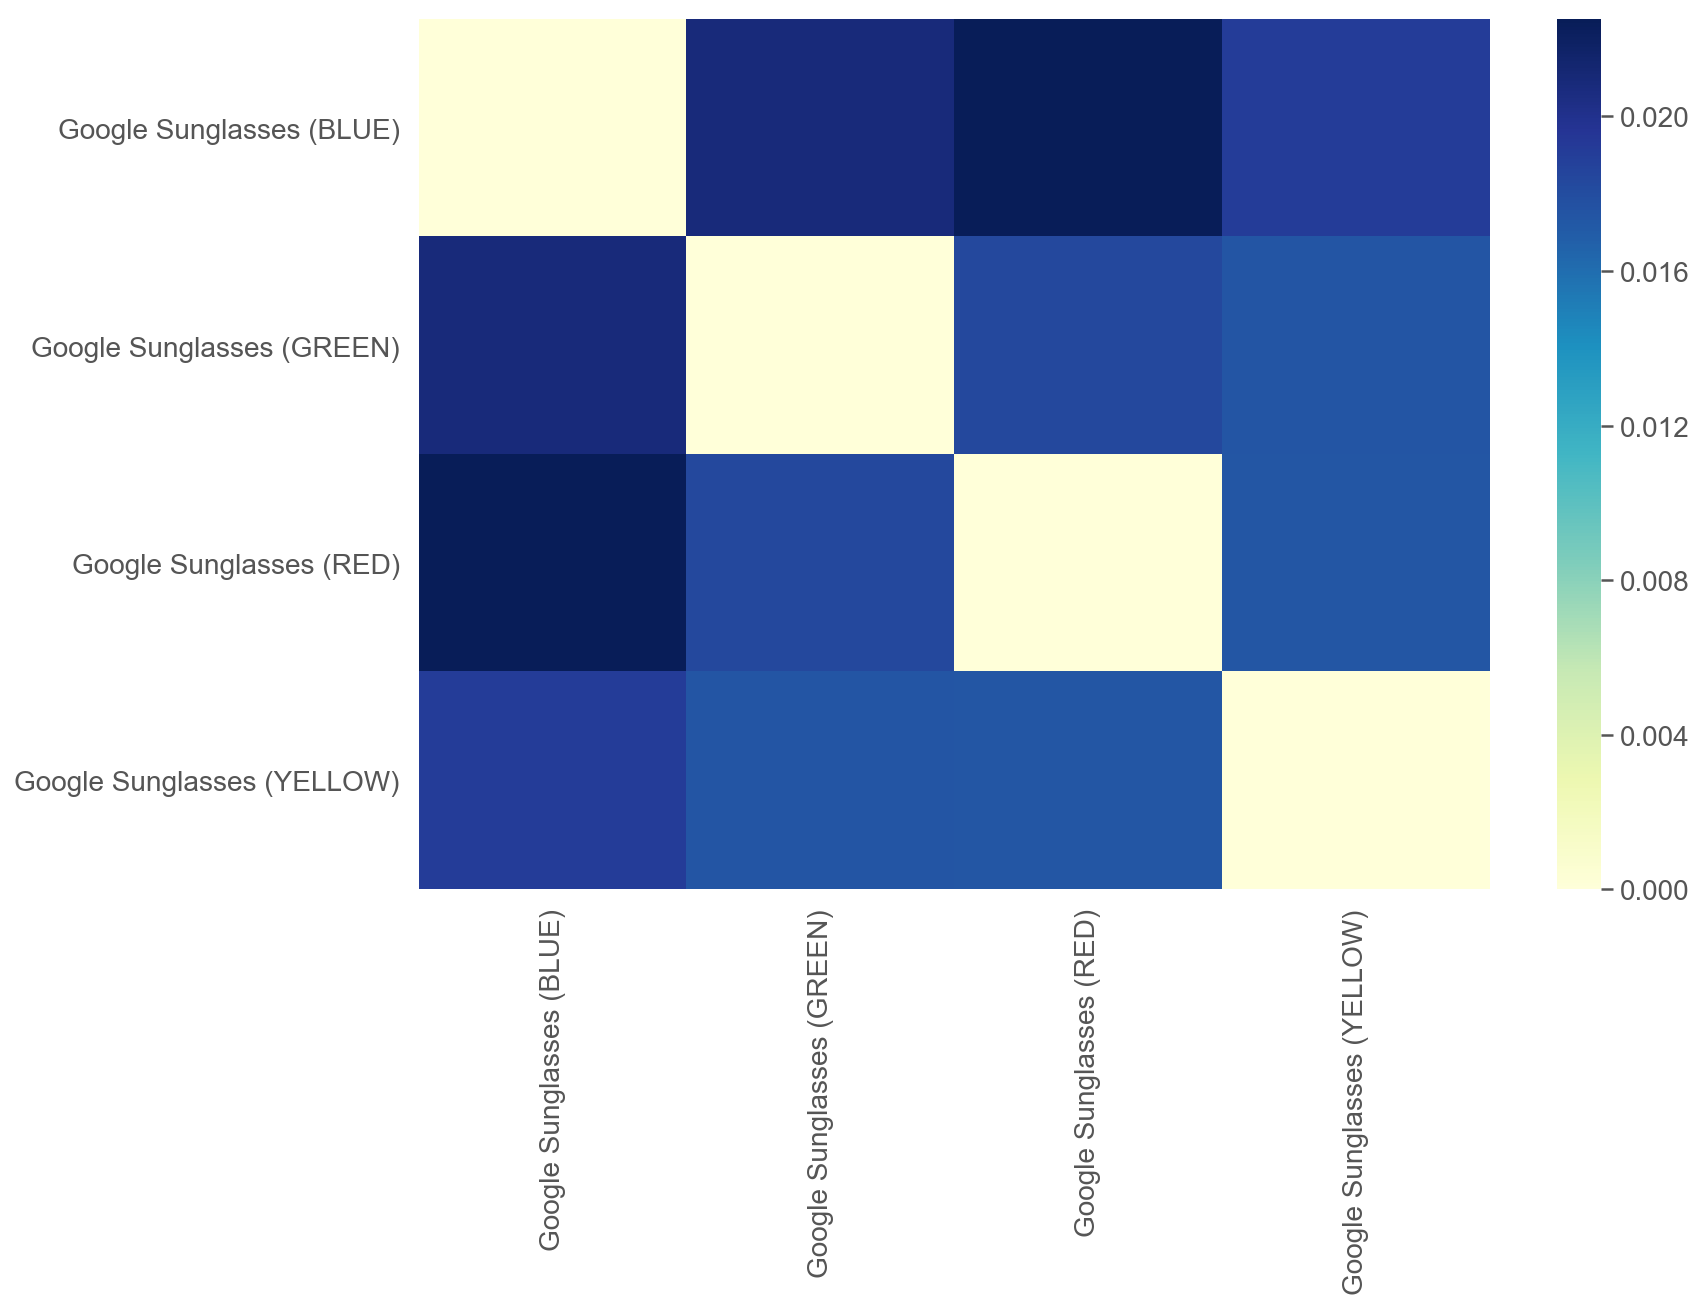

In [27]:
m = (
    (frequent_itemsets.itemsets.apply(len) == 2)
    & (frequent_itemsets.itemsets.apply(lambda x: all(('Sunglasses' in _x for _x in x))))
)
data_1 = frequent_itemsets[m].copy()
data_2 = frequent_itemsets[m].copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for pairs of sunglasses in transactions:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_sunglasses_combinations')

How about stuff that doesn't include sunglasses ;)

In [28]:
(frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)
                    & (~(frequent_itemsets.itemsets.astype(str).str.contains('Sunglasses')))]
     .sort_values('support', ascending=False).head(10))

support  \
1092  0.017835   
1465  0.009784   
758   0.009351   
1257  0.008918   
1185  0.008052   
727   0.007706   
1099  0.007013   
1243  0.007013   
1240  0.007013   
1238  0.006667   

                                                                            itemsets  
1092             (Google 22 oz Water Bottle (BLUE), Google 22 oz Water Bottle (RED))  
1465           (Recycled Paper Journal Set (BLUE), Recycled Paper Journal Set (RED))  
758   (Google Laptop and Cell Phone Stickers, Android Sticker Sheet Ultra Removable)  
1257                  (Google Laptop and Cell Phone Stickers, YouTube Custom Decals)  
1185                    (Google Laptop and Cell Phone Stickers, Google Doodle Decal)  
727              (Google Laptop and Cell Phone Stickers, 8 pc Android Sticker Sheet)  
1099       (Google Laptop and Cell Phone Stickers, Google 22 oz Water Bottle (BLUE))  
1243                     (Google Laptop and Cell Phone Stickers, Recycled Mouse Pad)  
1240                               (Maze Pen, Google Laptop and Cell Phone Stickers)  
1238                   (Google Laptop and Cell Phone Stickers, Keyboard DOT Sticker)

Support for top pairs of items:


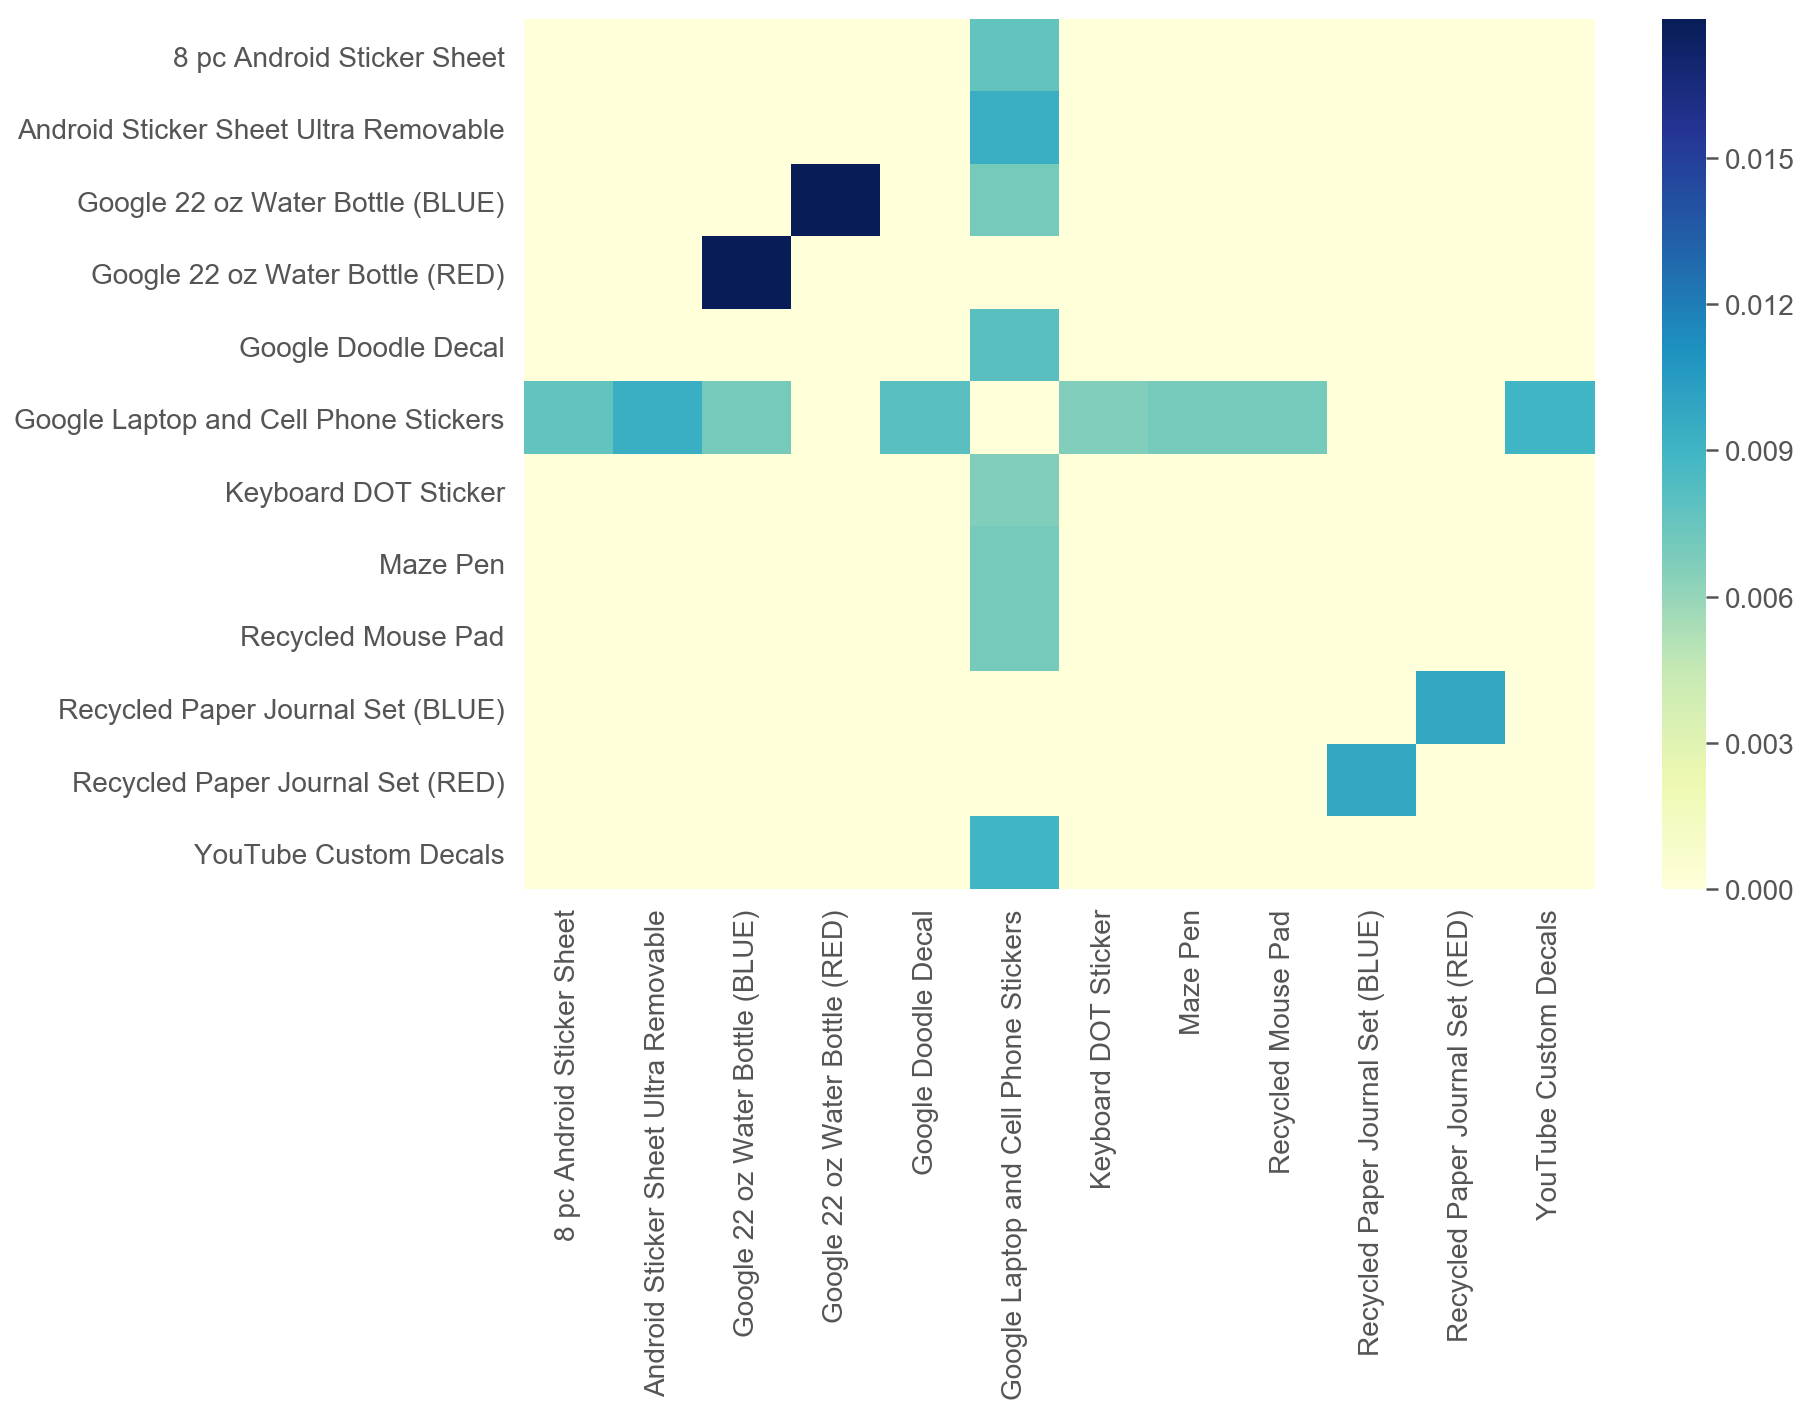

In [29]:
most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)
                    & (~(frequent_itemsets.itemsets.astype(str).str.contains('Sunglasses')))]
                     .sort_values('support', ascending=False).head(10))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_10_including_variations')


Support for top pairs of items:


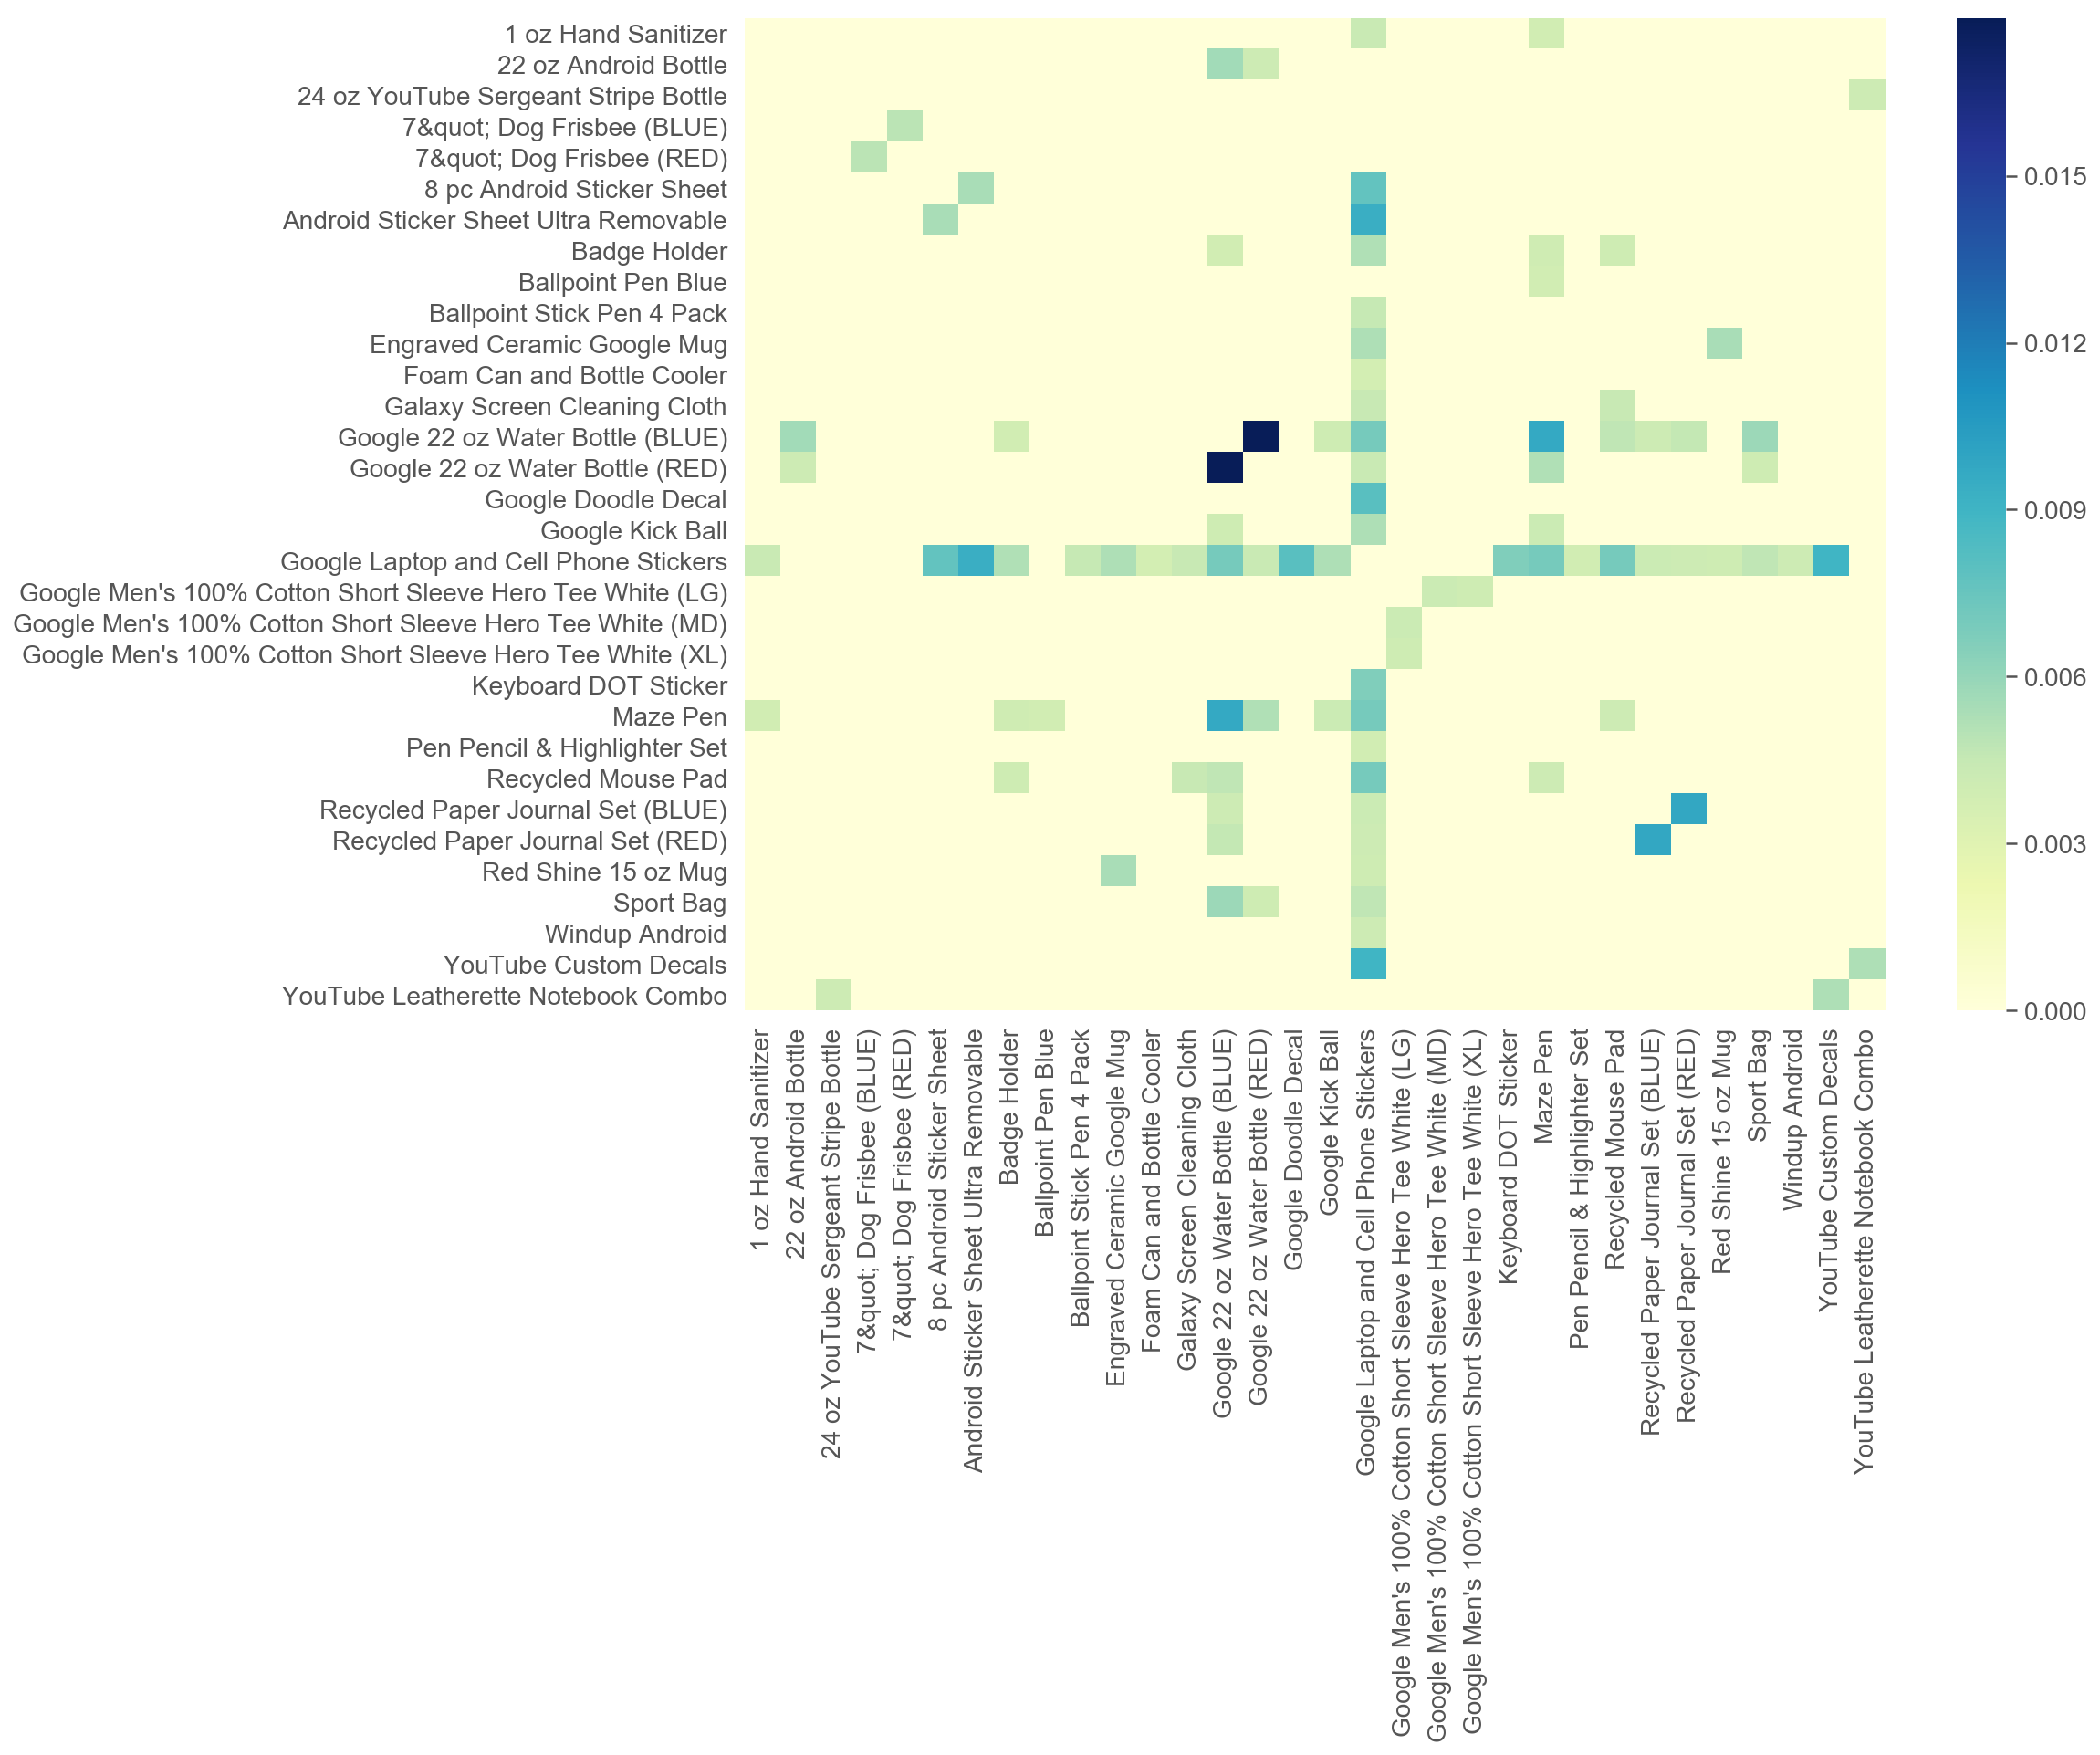

In [30]:
plt.figure(figsize=(14, 10))

most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)
                    & (~(frequent_itemsets.itemsets.astype(str).str.contains('Sunglasses')))]
                     .sort_values('support', ascending=False).head(50))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_50_including_variations')


Notice how laptop stickers are a common add-on item for a large variety of other products.

### Association rules (including product variants)

Mining association rules from item sets. Note:

[source -> mlxtend docs](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets)

> The confidence of a rule A->C is the probability of seeing the consequent in a transaction given that it also contains the antecedent

In [21]:
rules = association_rules(frequent_itemsets)

In [22]:
rules.sort_values('confidence', ascending=False).head()

antecedents  \
257  (Google Sunglasses (YELLOW), Google Sunglasses (RED), Google Sunglasses (GREEN), Google 22 oz Water Bottle (RED))   
119                                 (Google Sunglasses (YELLOW), Google Sunglasses (RED), Engraved Ceramic Google Mug)   
38                                                                 (Google 22 oz Water Bottle (RED), Google Twill Cap)   
148             (Recycled Paper Journal Set (BLUE), Google 22 oz Water Bottle (RED), Recycled Paper Journal Set (RED))   
198                                                    (Google Sunglasses (RED), Google Sunglasses (GREEN), Sport Bag)   

                            consequents  antecedent support  \
257          (Google Sunglasses (BLUE))            0.001039   
119          (Google Sunglasses (BLUE))            0.001126   
38   (Google 22 oz Water Bottle (BLUE))            0.001039   
148  (Google 22 oz Water Bottle (BLUE))            0.002251   
198          (Google Sunglasses (BLUE))            0.001472   

     consequent support   support  confidence       lift  leverage  conviction  
257            0.037403  0.001039         1.0  26.736111  0.001000         inf  
119            0.037403  0.001126         1.0  26.736111  0.001083         inf  
38             0.040606  0.001039         1.0  24.626866  0.000997         inf  
148            0.040606  0.002251         1.0  24.626866  0.002160         inf  
198            0.037403  0.001472         1.0  26.736111  0.001417         inf

Loads of these have high confidence, but they are not very frequent (low support).

Given the nature of this dataset, I think it's better to sort by `support`

In [33]:
rules.sort_values('antecedent support', ascending=False).head(10)

antecedents  \
1                               (Google Sunglasses (YELLOW))   
64     (Google Sunglasses (BLUE), Google Sunglasses (GREEN))   
72    (Google Sunglasses (BLUE), Google Sunglasses (YELLOW))   
66    (Google Sunglasses (BLUE), Google Sunglasses (YELLOW))   
65      (Google Sunglasses (GREEN), Google Sunglasses (RED))   
87      (Google Sunglasses (GREEN), Google Sunglasses (RED))   
194     (Google Sunglasses (GREEN), Google Sunglasses (RED))   
67   (Google Sunglasses (YELLOW), Google Sunglasses (GREEN))   
192  (Google Sunglasses (YELLOW), Google Sunglasses (GREEN))   
85   (Google Sunglasses (YELLOW), Google Sunglasses (GREEN))   

                                                consequents  \
1                                (Google Sunglasses (BLUE))   
64                                (Google Sunglasses (RED))   
72                                (Google Sunglasses (RED))   
66                              (Google Sunglasses (GREEN))   
65                               (Google Sunglasses (BLUE))   
87                             (Google Sunglasses (YELLOW))   
194  (Google Sunglasses (BLUE), Google Sunglasses (YELLOW))   
67                               (Google Sunglasses (BLUE))   
192     (Google Sunglasses (BLUE), Google Sunglasses (RED))   
85                                (Google Sunglasses (RED))   

     antecedent support  consequent support   support  confidence       lift  \
1              0.022338            0.037403  0.019134    0.856589  22.901863   
64             0.020866            0.029177  0.017229    0.825726  28.300110   
72             0.019134            0.029177  0.016623    0.868778  29.775635   
66             0.019134            0.027446  0.016104    0.841629  30.665030   
65             0.018355            0.037403  0.017229    0.938679  25.096633   
87             0.018355            0.022338  0.015238    0.830189  37.165423   
194            0.018355            0.019134  0.014719    0.801887  41.908563   
67             0.017489            0.037403  0.016104    0.920792  24.618399   
192            0.017489            0.022511  0.014719    0.841584  37.385758   
85             0.017489            0.029177  0.015238    0.871287  29.861621   

     leverage  conviction  
1    0.018299    6.712166  
64   0.016621    5.570672  
72   0.016065    7.398337  
66   0.015579    6.140985  
65   0.016543   15.697742  
87   0.014828    5.757345  
194  0.014367    4.951037  
67   0.015450   12.152792  
192  0.014325    6.170400  
85   0.014728    7.542544

In [23]:
m_yellow_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (YELLOW)' in x)
m_blue_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (BLUE)' in x)
m_y_and_b_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (YELLOW)' in x and 'Google Sunglasses (BLUE)' in x)

In [24]:
print('{} transactions with yellow sunglasses'.format(m_yellow_sunglasses.sum()))
print('{} transactions with blue sunglasses'.format(m_blue_sunglasses.sum()))
print('{} transactions with both'.format(m_y_and_b_sunglasses.sum()))
print('> {:.0f}% of yellow orders have blue'.format(m_y_and_b_sunglasses.sum() / m_yellow_sunglasses.sum() * 100))
print('> {:.0f}% of blue orders have yellow'.format(m_y_and_b_sunglasses.sum() / m_blue_sunglasses.sum() * 100))

258 transactions with yellow sunglasses
432 transactions with blue sunglasses
221 transactions with both
> 86% of yellow orders have blue
> 51% of blue orders have yellow


In [27]:
m_red_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (RED)' in x)
m_blue_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (BLUE)' in x)
m_r_and_b_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (RED)' in x and 'Google Sunglasses (BLUE)' in x)

print('{} transactions with red sunglasses'.format(m_red_sunglasses.sum()))
print('{} transactions with blue sunglasses'.format(m_blue_sunglasses.sum()))
print('{} transactions with both'.format(m_r_and_b_sunglasses.sum()))
print('> {:.0f}% of red orders have blue'.format(m_r_and_b_sunglasses.sum() / m_red_sunglasses.sum() * 100))
print('> {:.0f}% of blue orders have red'.format(m_r_and_b_sunglasses.sum() / m_blue_sunglasses.sum() * 100))

337 transactions with red sunglasses
432 transactions with blue sunglasses
260 transactions with both
> 77% of red orders have blue
> 60% of blue orders have red


This can be used as the basis for a recommendation engine, or to inform marketing and product design decisions.

Ignoring the sunglasses...

In [28]:
m_no_sunglasses = (~(rules.antecedents.astype(str).str.contains('Sunglasses'))) & (~(rules.consequents.astype(str).str.contains('Sunglasses')))
rules[m_no_sunglasses].sort_values('antecedent support', ascending=False).head(10)

antecedents  \
23                                                            (YouTube Custom Decals, Android Sticker Sheet Ultra Removable)   
147                    (Google 22 oz Water Bottle (BLUE), Google 22 oz Water Bottle (RED), Recycled Paper Journal Set (RED))   
62    (Google Men's 100% Cotton Short Sleeve Hero Tee White (MD), Google Men's 100% Cotton Short Sleeve Hero Tee White (XL))   
58    (Google Men's 100% Cotton Short Sleeve Hero Tee Black (XL), Google Men's 100% Cotton Short Sleeve Hero Tee Black (MD))   
146                   (Google 22 oz Water Bottle (BLUE), Recycled Paper Journal Set (BLUE), Google 22 oz Water Bottle (RED))   
28                                                                           (Google 22 oz Water Bottle (RED), Badge Holder)   
11                                                                            (7&quot; Dog Frisbee (BLUE), Google Kick Ball)   
148                   (Recycled Paper Journal Set (BLUE), Google 22 oz Water Bottle (RED), Recycled Paper Journal Set (RED))   
0                                                                                         (22 oz Mini Mountain Bottle (RED))   
54   (Google Men's 100% Cotton Short Sleeve Hero Tee Black (2XL), Google Men's 100% Cotton Short Sleeve Hero Tee Black (MD))   

                                                     consequents  \
23                       (Google Laptop and Cell Phone Stickers)   
147                          (Recycled Paper Journal Set (BLUE))   
62   (Google Men's 100% Cotton Short Sleeve Hero Tee White (LG))   
58   (Google Men's 100% Cotton Short Sleeve Hero Tee Black (LG))   
146                           (Recycled Paper Journal Set (RED))   
28                            (Google 22 oz Water Bottle (BLUE))   
11                                   (7&quot; Dog Frisbee (RED))   
148                           (Google 22 oz Water Bottle (BLUE))   
0                            (22 oz Mini Mountain Bottle (BLUE))   
54   (Google Men's 100% Cotton Short Sleeve Hero Tee Black (LG))   

     antecedent support  consequent support   support  confidence        lift  \
23             0.002771            0.067706  0.002424    0.875000   12.923593   
147            0.002771            0.017835  0.002251    0.812500   45.555218   
62             0.002771            0.020260  0.002251    0.812500   40.104167   
58             0.002597            0.017403  0.002165    0.833333   47.885572   
146            0.002511            0.018182  0.002251    0.896552   49.310345   
28             0.002338            0.040606  0.001991    0.851852   20.978441   
11             0.002338            0.007965  0.001905    0.814815  102.294686   
148            0.002251            0.040606  0.002251    1.000000   24.626866   
0              0.001905            0.002857  0.001558    0.818182  286.363636   
54             0.001818            0.017403  0.001472    0.809524   46.517413   

     leverage  conviction  
23   0.002237    7.458355  
147  0.002202    5.238211  
62   0.002195    5.225281  
58   0.002119    5.895584  
146  0.002205    9.490909  
28   0.001896    6.475909  
11   0.001886    5.356987  
148  0.002160         inf  
0    0.001553    5.484286  
54   0.001440    5.158636

In [29]:
rules['rule'] = rules.antecedents.apply(list).astype(str) + '  ->  ' + rules.consequents.apply(list).astype(str)

In [36]:
s = (
    rules[m_no_sunglasses].sort_values('support', ascending=False)
         .head(10)[['rule', 'support', 'confidence']]
         .set_index('rule')
         .style
)
s.bar(subset=['support', 'confidence'], color='#a5a5a5', width=90)

### Frequent items & association rules (excluding product variants)

In [39]:
df_itemsets_by_transaction_no_variants.head()

v2ProductName
transactionId                                                                                                                                                                                                 
1470046365|4166700707688517424                                              [UFO Bluetooth Water Resistant Speaker, Women's YouTube Short Sleeve Hero Tee Black, YouTube Men's Short Sleeve Hero Tee Charcoal]
1470057237|3213840074316400693                                                                                                 [Electronics Accessory Pouch, Badge Holder, Color Changing Grip Pen, Kick Ball]
1470063041|6485652672428047343                                                                                [Electronics Accessory Pouch, Red Spiral Google Notebook, Google Sunglasses, Recycled Mouse Pad]
1470063685|6997692197808690953               [24 oz USA Made Aluminum Bottle, Google Toddler Short Sleeve T-shirt Grey, Android Toddler Short Sleeve T-shirt Pink, Blue Metallic Textured Spiral Notebook Set]
1470064251|3006489767948351126  [Android 24 oz Contigo Addison, Google Men's 100% Cotton Short Sleeve Hero Tee White, Engraved Ceramic Google Mug, 26 oz Double Wall Insulated Bottle, Android Rise 14 oz Mug]

In [37]:
transactions = df_itemsets_by_transaction_no_variants['v2ProductName'].tolist()

In [38]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [39]:
df_te.head()

1 oz Hand Sanitizer  16 oz. Hot and Cold Tumbler  16 oz. Hot/Cold Tumbler  \
0                False                        False                    False   
1                False                        False                    False   
2                False                        False                    False   
3                False                        False                    False   
4                False                        False                    False   

   20 oz Stainless Steel Insulated Tumbler  22 oz Android Bottle  \
0                                    False                 False   
1                                    False                 False   
2                                    False                 False   
3                                    False                 False   
4                                    False                 False   

   22 oz Mini Mountain Bottle  22 oz YouTube Bottle Infuser  \
0                       False                         False   
1                       False                         False   
2                       False                         False   
3                       False                         False   
4                       False                         False   

   23 oz Wide Mouth Sport Bottle  24 oz USA Made Aluminum Bottle  \
0                          False                           False   
1                          False                           False   
2                          False                           False   
3                          False                            True   
4                          False                           False   

   24 oz YouTube Sergeant Stripe Bottle                 ...                  \
0                                 False                 ...                   
1                                 False                 ...                   
2                                 False                 ...                   
3                                 False                 ...                   
4                                 False                 ...                   

   YouTube Women's Fleece Hoodie Black  YouTube Women's Racer Back Tank Black  \
0                                False                                  False   
1                                False                                  False   
2                                False                                  False   
3                                False                                  False   
4                                False                                  False   

   YouTube Women's S/S Crew Tee  YouTube Women's Short Sleeve Crew Tee  \
0                         False                                  False   
1                         False                                  False   
2                         False                                  False   
3                         False                                  False   
4                         False                                  False   

   YouTube Women's Short Sleeve Hero Tee Charcoal  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal  \
0                                                      False   
1                                                      False   
2                                                      False   
3                                                      False   
4                                                      False   

   YouTube Women's Short Sleeve Tri-blend Badge Tee Grey  \
0                                                  False   
1                                                  False   
2                                 

In [40]:
frequent_itemsets = apriori(df_te, min_support=0.001, use_colnames=True)

[source -> mlxtend docs](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets)

> Typically, support is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database

In [41]:
frequent_itemsets.sort_values('support', ascending=False).head(10)

support                                                itemsets
148  0.107326                 (Google Laptop and Cell Phone Stickers)
102  0.071978                             (Google 22 oz Water Bottle)
220  0.071408                                     (Google Sunglasses)
156  0.065279  (Google Men's 100% Cotton Short Sleeve Hero Tee Black)
159  0.065137  (Google Men's 100% Cotton Short Sleeve Hero Tee White)
157  0.060006   (Google Men's 100% Cotton Short Sleeve Hero Tee Navy)
92   0.047605                           (Engraved Ceramic Google Mug)
319  0.044612                                    (Recycled Mouse Pad)
355  0.044327                                 (YouTube Custom Decals)
235  0.044042                                      (Google Twill Cap)

In [42]:
(frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
     .sort_values('support', ascending=False).head(10))

support  \
727   0.015393   
1509  0.014681   
1545  0.013826   
1276  0.013398   
1390  0.013255   
1260  0.013113   
1478  0.012828   
632   0.012685   
1293  0.012400   
1288  0.011688   

                                                                                                         itemsets  
727                                (Google Laptop and Cell Phone Stickers, Android Sticker Sheet Ultra Removable)  
1509                                               (Google Laptop and Cell Phone Stickers, YouTube Custom Decals)  
1545  (Google Men's 100% Cotton Short Sleeve Hero Tee Black, Google Men's 100% Cotton Short Sleeve Hero Tee Navy)  
1276                                                               (Google 22 oz Water Bottle, Google Sunglasses)  
1390                                                 (Google Laptop and Cell Phone Stickers, Google Doodle Decal)  
1260                                           (Google Laptop and Cell Phone Stickers, Google 22 oz Water Bottle)  
1478                                                   (Google Laptop and Cell Phone Stickers, Google Sunglasses)  
632                                           (Google Laptop and Cell Phone Stickers, 8 pc Android Sticker Sheet)  
1293                                                      (Google 22 oz Water Bottle, Recycled Paper Journal Set)  
1288                                                                        (Google 22 oz Water Bottle, Maze Pen)

Support for top pairs of items:


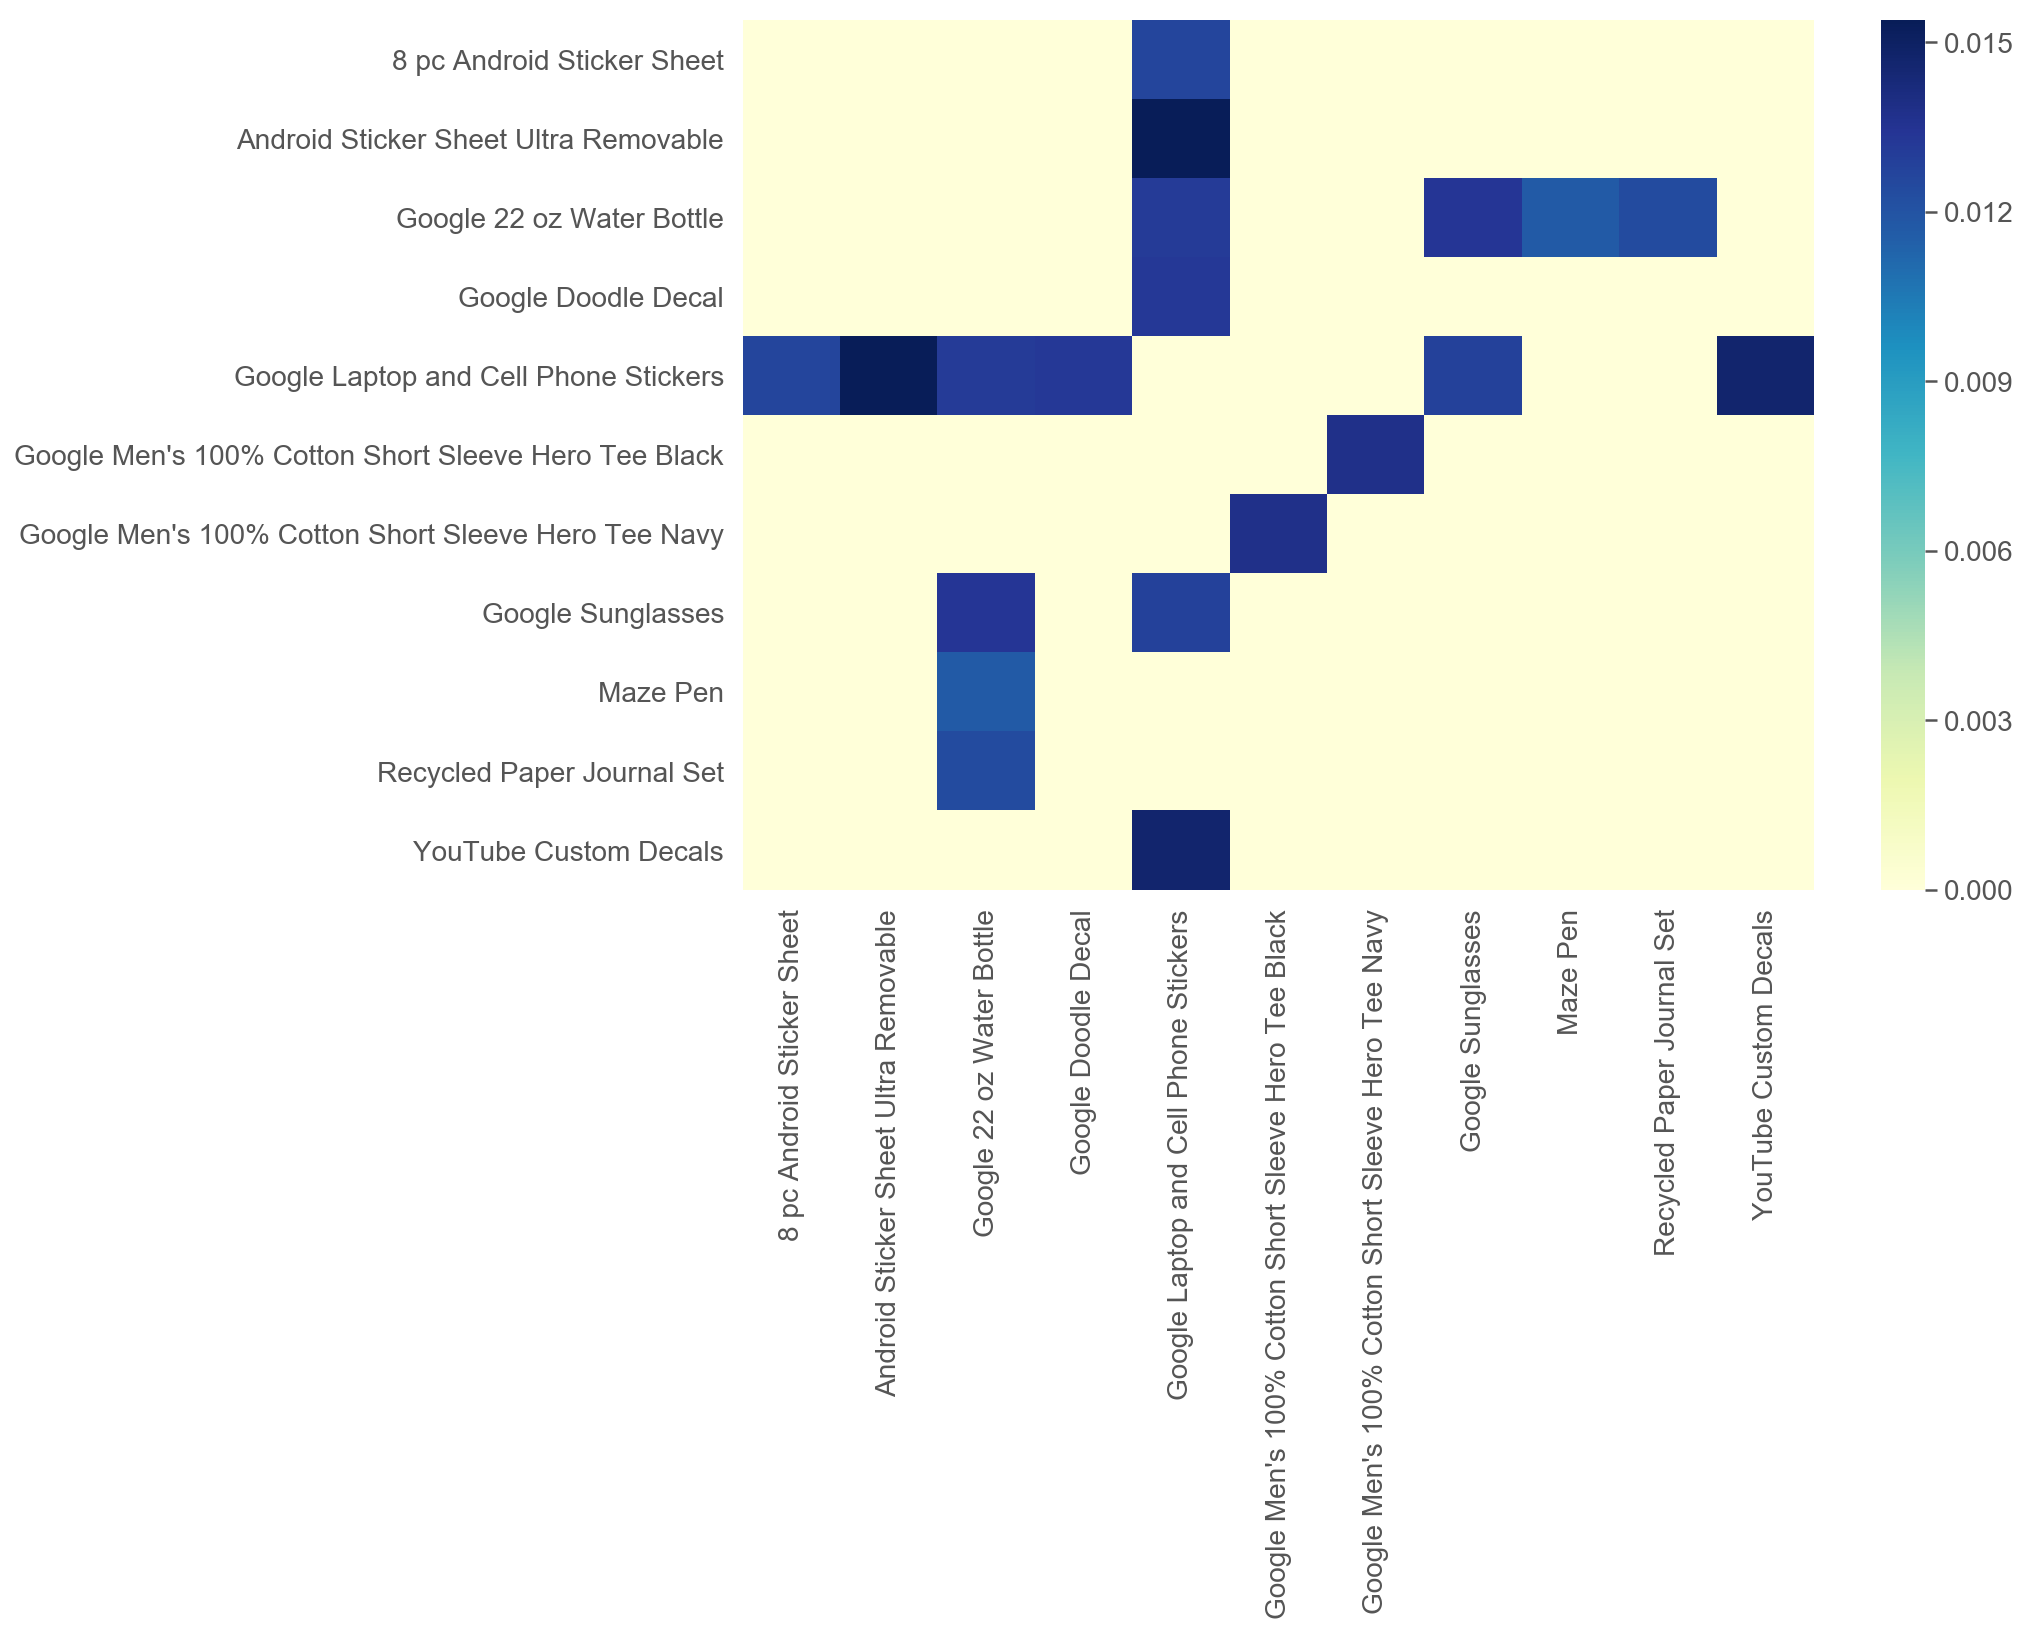

In [46]:
most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
                     .sort_values('support', ascending=False).head(10))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_10')

Support for top pairs of items:


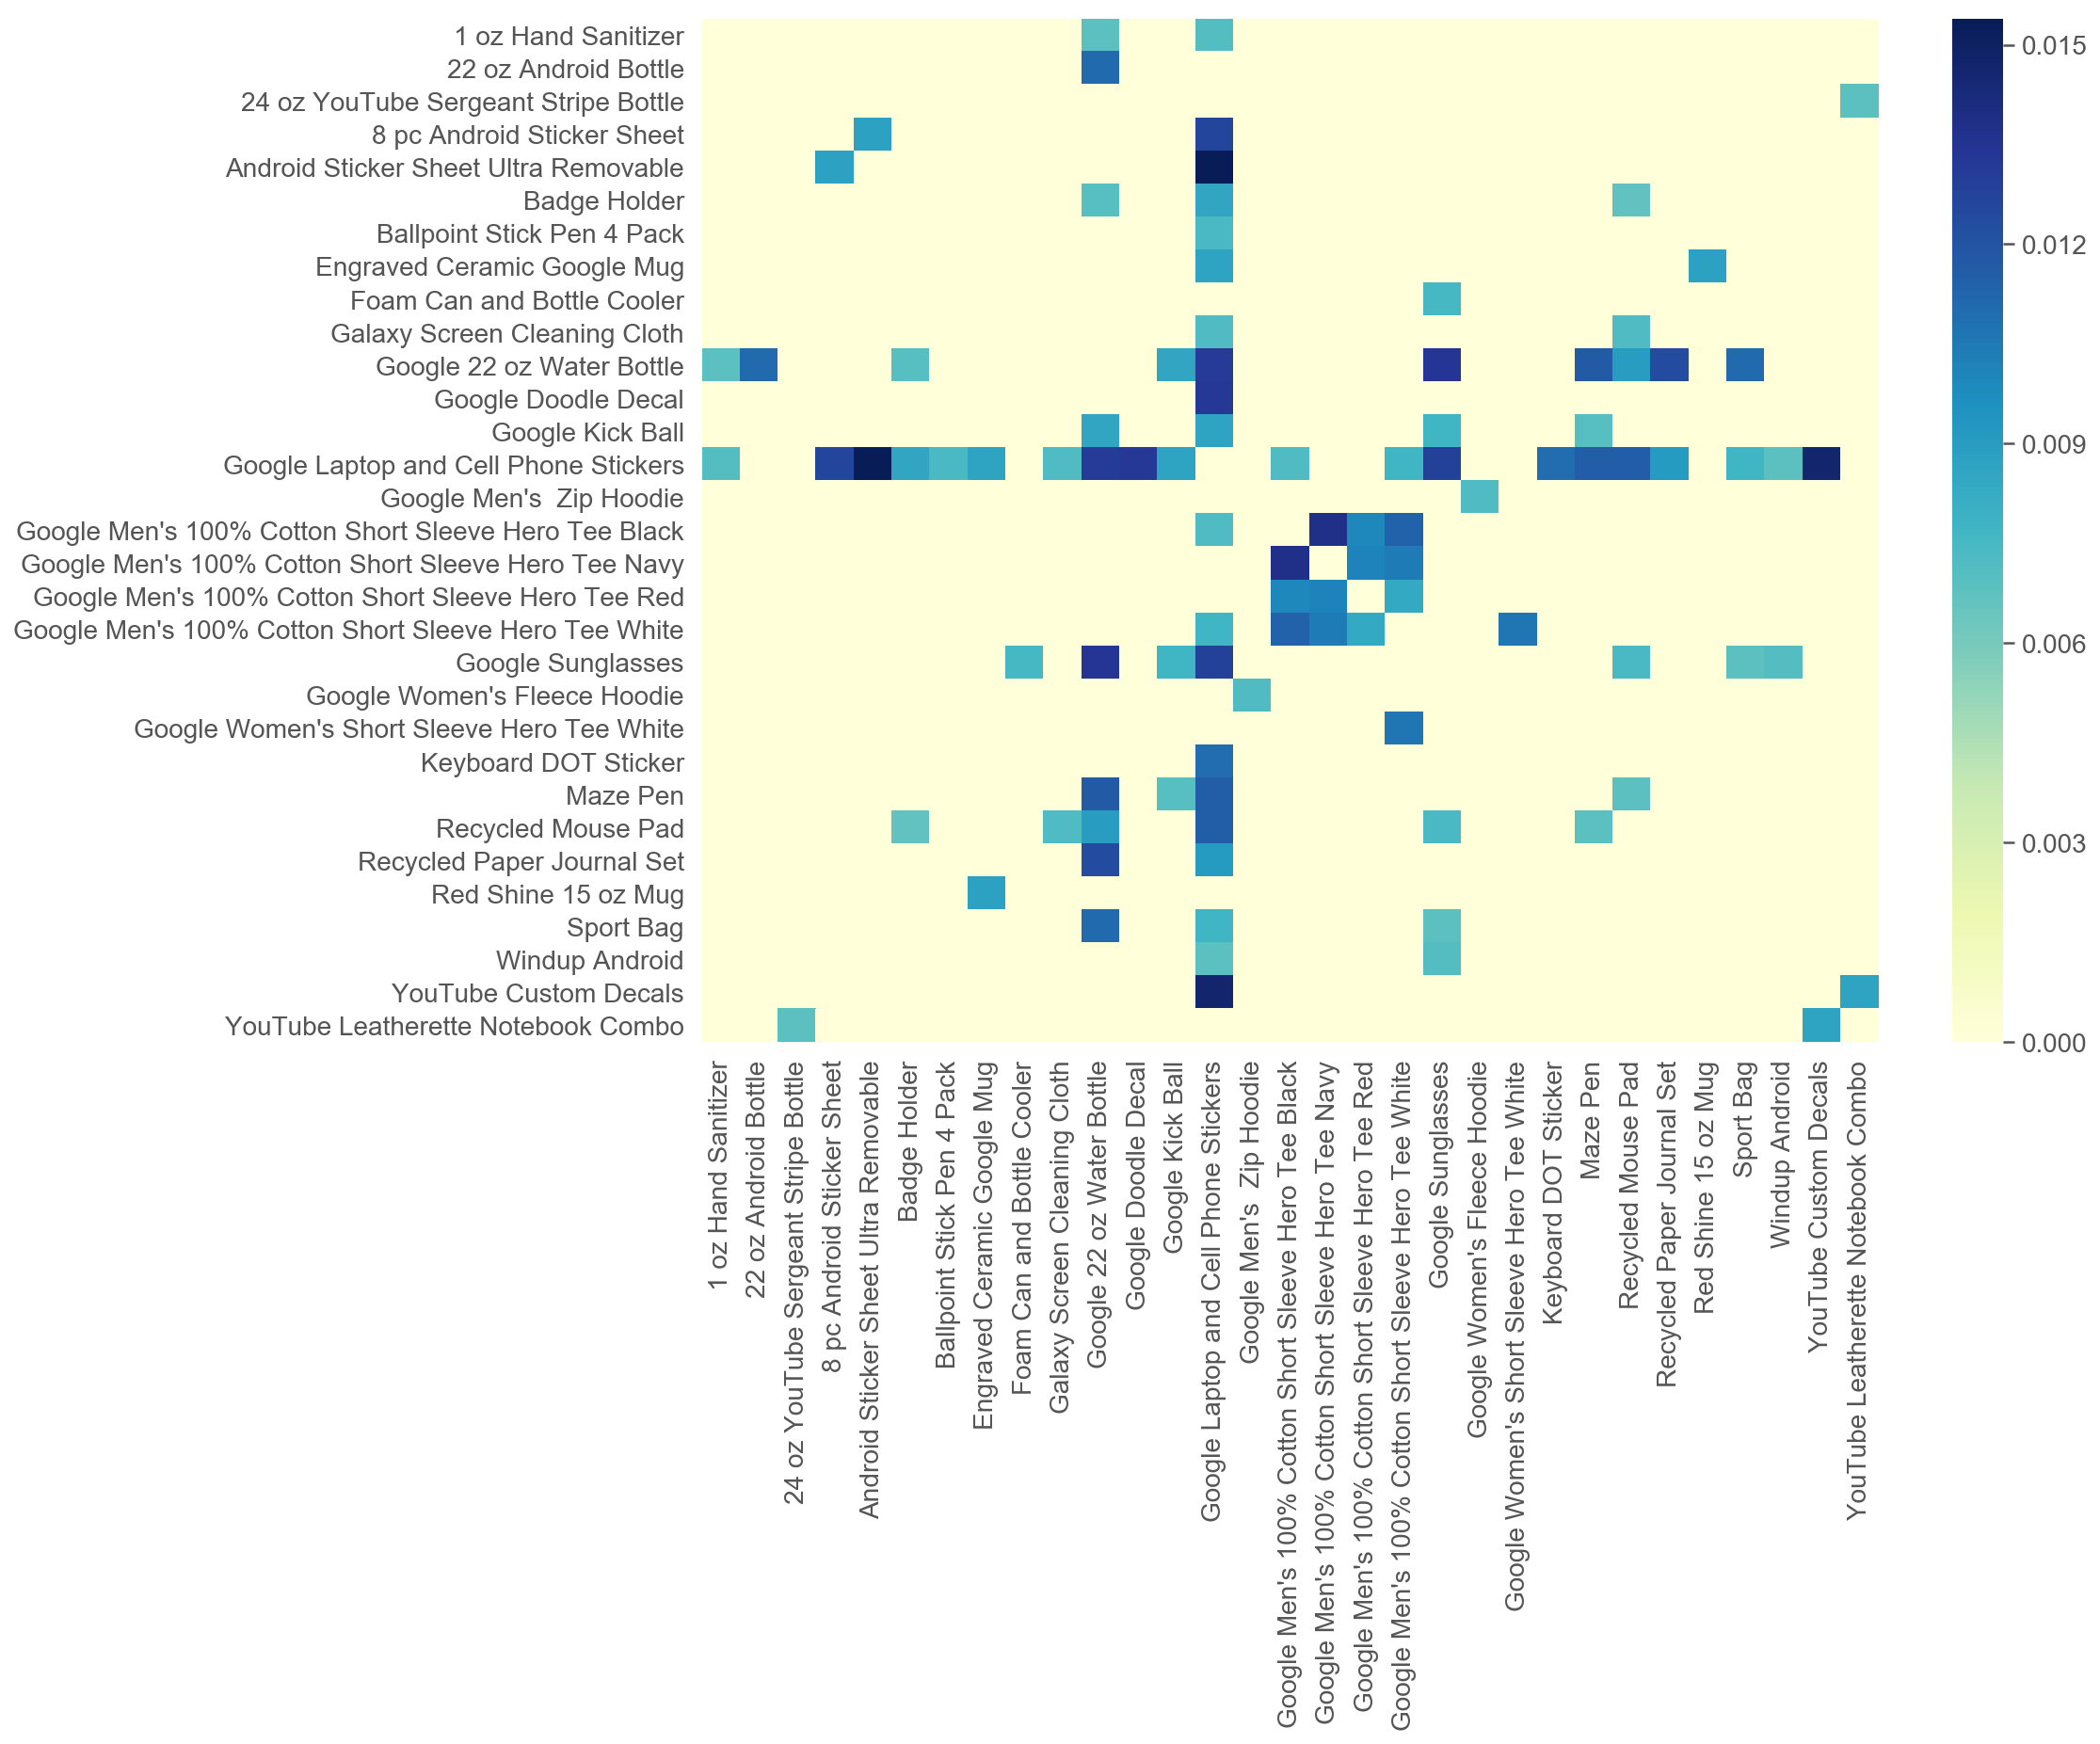

In [47]:
plt.figure(figsize=(14, 10))

most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
                     .sort_values('support', ascending=False).head(50))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_50')

In [43]:
rules = association_rules(frequent_itemsets)

In [49]:
rules.sort_values('confidence', ascending=False).head()

antecedents  \
4                     (Maze Pen, Android Sticker Sheet Ultra Removable)   
2   (Android Sticker Sheet Ultra Removable, Ballpoint Stick Pen 4 Pack)   
15                  (Maze Pen, Sport Bag, Galaxy Screen Cleaning Cloth)   
14                                  (Badge Holder, Maze Pen, Sport Bag)   
10          (Recycled Paper Journal Set, Retractable Ballpoint Pen Red)   

                                consequents  antecedent support  \
4   (Google Laptop and Cell Phone Stickers)            0.002281   
2   (Google Laptop and Cell Phone Stickers)            0.001425   
15              (Google 22 oz Water Bottle)            0.001425   
14              (Google 22 oz Water Bottle)            0.001425   
10              (Google 22 oz Water Bottle)            0.001425   

    consequent support   support  confidence       lift  leverage  conviction  
4             0.107326  0.002138      0.9375   8.735060  0.001893   14.282782  
2             0.107326  0.001283      0.9000   8.385657  0.001130    8.926739  
15            0.071978  0.001283      0.9000  12.503762  0.001180    9.280217  
14            0.071978  0.001283      0.9000  12.503762  0.001180    9.280217  
10            0.071978  0.001283      0.9000  12.503762  0.001180    9.280217

In [49]:
rules.sort_values('antecedent support', ascending=False).head(10)

antecedents  \
7                (YouTube Custom Decals, Android Sticker Sheet Ultra Removable)   
4                             (Maze Pen, Android Sticker Sheet Ultra Removable)   
5                  (Red Shine 15 oz Mug, Android Sticker Sheet Ultra Removable)   
6                            (Android Sticker Sheet Ultra Removable, Sport Bag)   
0                    (Galaxy Screen Cleaning Cloth, 8 pc Android Sticker Sheet)   
10                  (Recycled Paper Journal Set, Retractable Ballpoint Pen Red)   
15                          (Galaxy Screen Cleaning Cloth, Maze Pen, Sport Bag)   
14                                          (Maze Pen, Badge Holder, Sport Bag)   
12                  (Ballpoint Pen Blue, 1 oz Hand Sanitizer, Google Kick Ball)   
11  (Google Men's 100% Cotton Short Sleeve Hero Tee White, Google Doodle Decal)   

                                consequents  antecedent support  \
7   (Google Laptop and Cell Phone Stickers)            0.004561   
4   (Google Laptop and Cell Phone Stickers)            0.002281   
5   (Google Laptop and Cell Phone Stickers)            0.002138   
6   (Google Laptop and Cell Phone Stickers)            0.001568   
0   (Google Laptop and Cell Phone Stickers)            0.001425   
10              (Google 22 oz Water Bottle)            0.001425   
15              (Google 22 oz Water Bottle)            0.001425   
14              (Google 22 oz Water Bottle)            0.001425   
12                               (Maze Pen)            0.001425   
11  (Google Laptop and Cell Phone Stickers)            0.001425   

    consequent support   support  confidence       lift  leverage  conviction  \
7             0.107326  0.003991    0.875000   8.152722  0.003501    7.141391   
4             0.107326  0.002138    0.937500   8.735060  0.001893   14.282782   
5             0.107326  0.001853    0.866667   8.075077  0.001623    6.695054   
6             0.107326  0.001283    0.818182   7.623325  0.001115    4.909706   
0             0.107326  0.001140    0.800000   7.453918  0.000987    4.463369   
10            0.071978  0.001283    0.900000  12.503762  0.001180    9.280217   
15            0.071978  0.001283    0.900000  12.503762  0.001180    9.280217   
14            0.071978  0.001283    0.900000  12.503762  0.001180    9.280217   
12            0.043615  0.001140    0.800000  18.342484  0.001078    4.781927   
11            0.107326  0.001140    0.800000   7.453918  0.000987    4.463369   

                                                                                                                              rule  
7                ['YouTube Custom Decals', 'Android Sticker Sheet Ultra Removable']  ->  ['Google Laptop and Cell Phone Stickers']  
4                             ['Maze Pen', 'Android Sticker Sheet Ultra Removable']  ->  ['Google Laptop and Cell Phone Stickers']  
5                  ['Red Shine 15 oz Mug', 'Android Sticker Sheet Ultra Removable']  ->  ['Google Laptop and Cell Phone Stickers']  
6                            ['Android Sticker Sheet Ultra Removable', 'Sport Bag']  ->  ['Google Laptop and Cell Phone Stickers']  
0                    ['Galaxy Screen Cleaning Cloth', '8 pc Android Sticker Sheet']  ->  ['Google Laptop and Cell Phone Stickers']  
10                              ['Recycled Paper Journal Set', 'Retractable Ballpoint Pen Red']  ->  ['Google 22 oz Water Bottle']  
15                                    ['Galaxy Screen Cleaning Cloth', 'Maze Pen', 'Sport Bag']  ->  ['Google 22 oz Water Bottle']  
14                                                    ['Maze Pen', 'Badge Holder', 'Sport Bag']  ->  ['Google 22 oz Water Bottle']  
12                                             ['Ballpoint Pen Blue', '1 oz Hand Sanitizer', 'Google Kick Ball']  ->  ['Maze Pen']  
11  ["Google Men's 100% Cotton Short Sleeve Hero Tee White", 'Google Doodle Decal']  ->  ['Google Laptop and Cell Phone Stickers']

In [44]:
rules['rule'] = rules.antecedents.apply(list).astype(str) + '  ->  ' + rules.consequents.apply(list).astype(str)

In [50]:
s = (
    rules.sort_values('support', ascending=False)
         .head(10)[['rule', 'support', 'confidence']]
         .set_index('rule')
         .style
)
s.bar(subset=['support', 'confidence'], color='#a5a5a5', width=90)

## Tracking Association Rules

In [81]:
transaction_date_map = df[['transactionId', 'date']].drop_duplicates()
misc_duplicates = transaction_date_map.transactionId.duplicated()
print('Dropping {} duplicate rows (this number should be very small)'
      .format(misc_duplicates.sum()))
transaction_date_map = (
    transaction_date_map[~misc_duplicates]
    .set_index('transactionId')['date']
)

df_itemsets_by_transaction_no_variants['date'] = (
    df_itemsets_by_transaction_no_variants.index.map(transaction_date_map)
)

Dropping 1 duplicate rows (this number should be very small)


In [116]:
df_itemsets_by_transaction_no_variants = df_itemsets_by_transaction_no_variants.reset_index()

In [246]:
from typing import List, Tuple
import hashlib

def get_association_rule_transactions(
    df : pd.DataFrame,
    rule : List[list],
    return_mask : bool = True,
) -> Tuple[pd.Series]:
    
    print('Warning: duplicate items in transactions will be ignored')
    s_transaction_sets = df.v2ProductName.apply(set)

    # Generate masks where rule is found in the transaction
    m_antecedents = (set(rule[0]) - s_transaction_sets).apply(len) == 0
    m_consequents = (set(rule[1]) - s_transaction_sets).apply(len) == 0

    m_follows_rule = m_antecedents & m_consequents
    m_breaks_rule = m_antecedents & (~m_follows_rule)
    
    if return_mask:
        return m_follows_rule, m_breaks_rule
    else:
        return df[m_follows_rule], df[m_breaks_rule]


def plot_association_rule_trend(
    df : pd.DataFrame,
    rule : List[list],
    save_to_file : bool = True,
) -> None:

    m_follows_rule, m_breaks_rule = get_association_rule_transactions(df, rule, return_mask=True)
    
    s_follows_rule = df_itemsets_by_transaction_no_variants[m_follows_rule].groupby(pd.Grouper(key='date', freq='W-MON')).size()
    s_breaks_rule = df_itemsets_by_transaction_no_variants[m_breaks_rule].groupby(pd.Grouper(key='date', freq='W-MON')).size()
    s_follows_rule.name = 'Follows Rule'
    s_breaks_rule.name = 'Breaks Rule'

    df_merge = pd.merge(
        s_follows_rule.to_frame().reset_index(),
        s_breaks_rule.to_frame().reset_index(),
        on='date',
        how='outer'
    ).set_index('date').sort_index()

    df_merge_cumsum = df_merge.cumsum().fillna(method='pad').fillna(method='backfill')
    df_merge_cumsum['Confidence Ratio'] = df_merge_cumsum['Follows Rule'] / (df_merge_cumsum['Breaks Rule'] + df_merge_cumsum['Follows Rule'])

    rule_str = ' -> '.join([str(x) for x in rule])
    print(rule_str)

    fig, ax = plt.subplots(2)
    df_merge_cumsum['Follows Rule'].plot(ax=ax[0], color='r', label='Follows Rule')
    df_merge_cumsum['Breaks Rule'].plot(ax=ax[0], color='b', label='Breaks Rule')
    df_merge_cumsum['Confidence Ratio'].plot(ax=ax[1], color='k', label='Confidence Ratio')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylabel('Cumulative Sum of Counts')
    ax[1].set_ylabel(r'$\Delta$(Follows, Breaks)')
    plt.xlabel('Date')

    if save_to_file:
        f_name = 'association_rules_trended_confidence_{}'.format(hashlib.sha1(rule_str.encode('utf-8')).hexdigest()[:10])
        savefig(f_name)

        f_name = os.path.join('../../results/figures', '{}.png.info.txt'.format(f_name))
        with open(f_name, 'w') as f:
            f.write('Plot for association rule:\n')
            f.write(rule_str)
            f.write('\n\n' + '#'*20 + '\n')
            f.write(df_merge.to_csv())

    plt.show()

['YouTube Custom Decals', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']


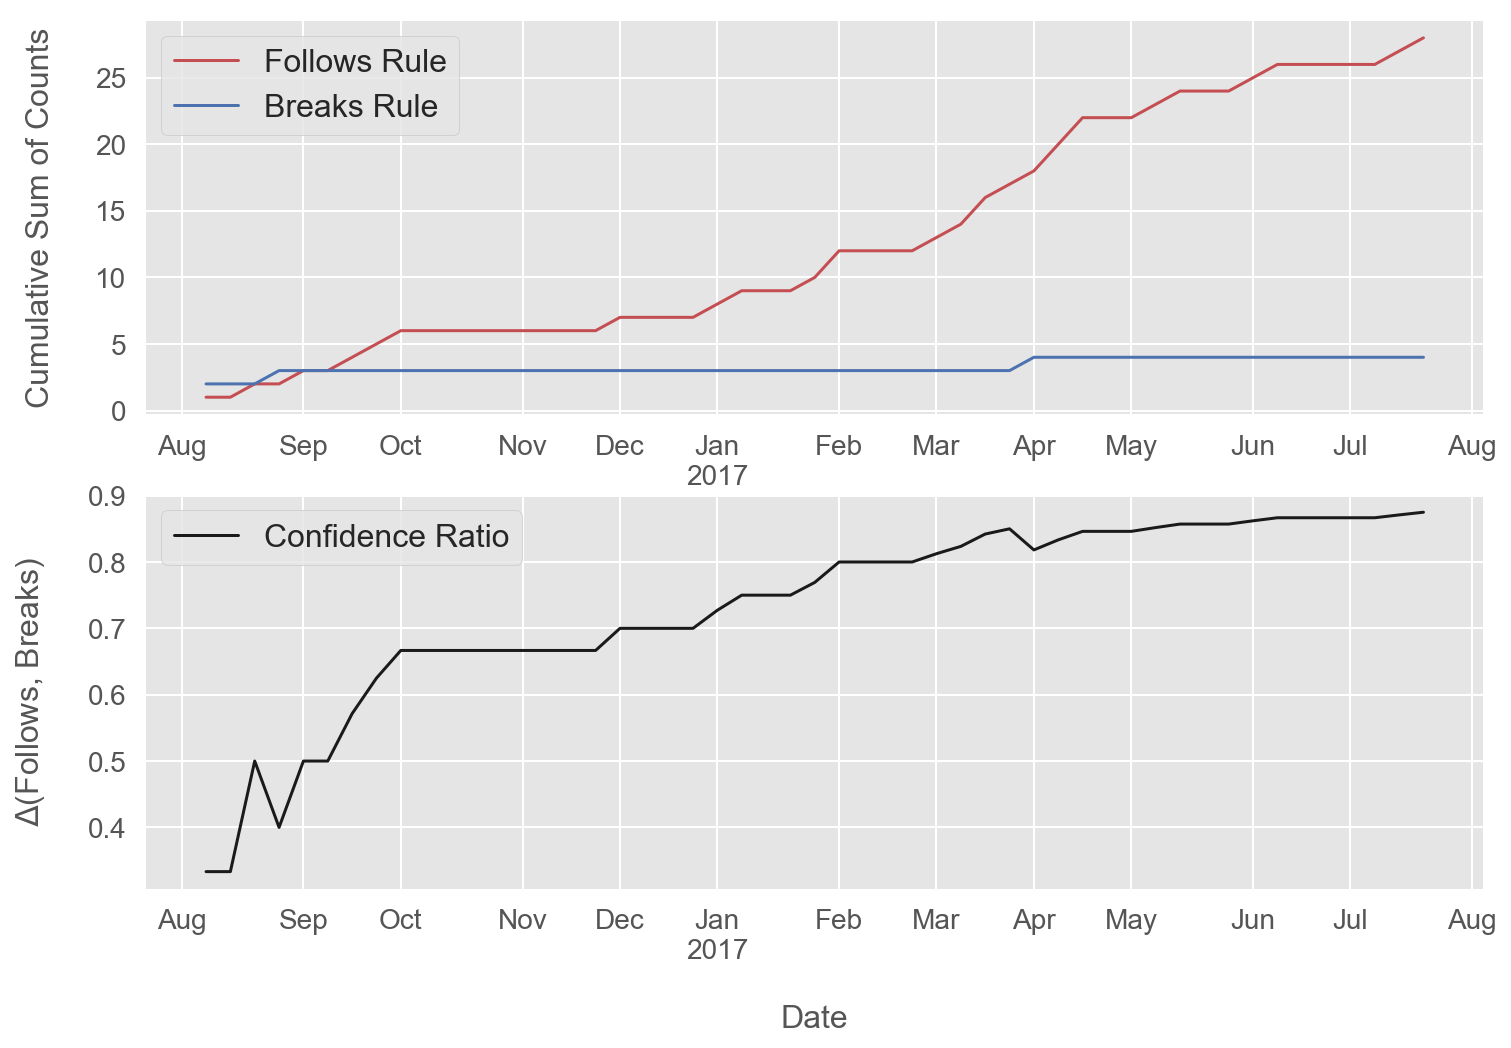

['Maze Pen', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']


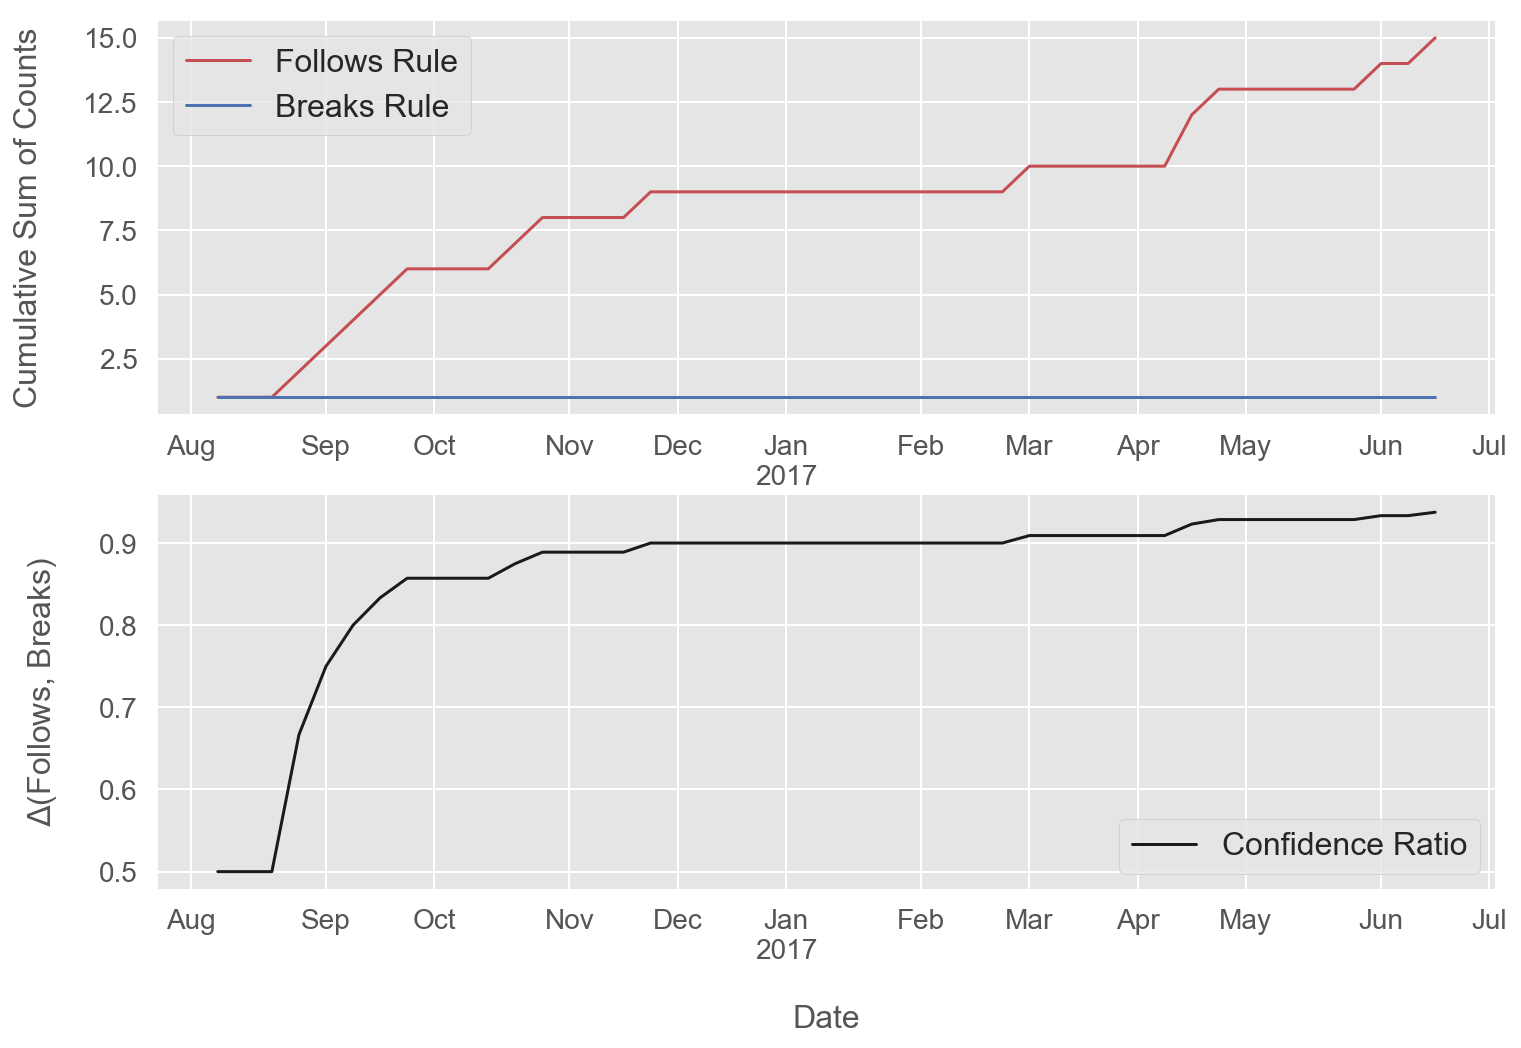

['Red Shine 15 oz Mug', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']


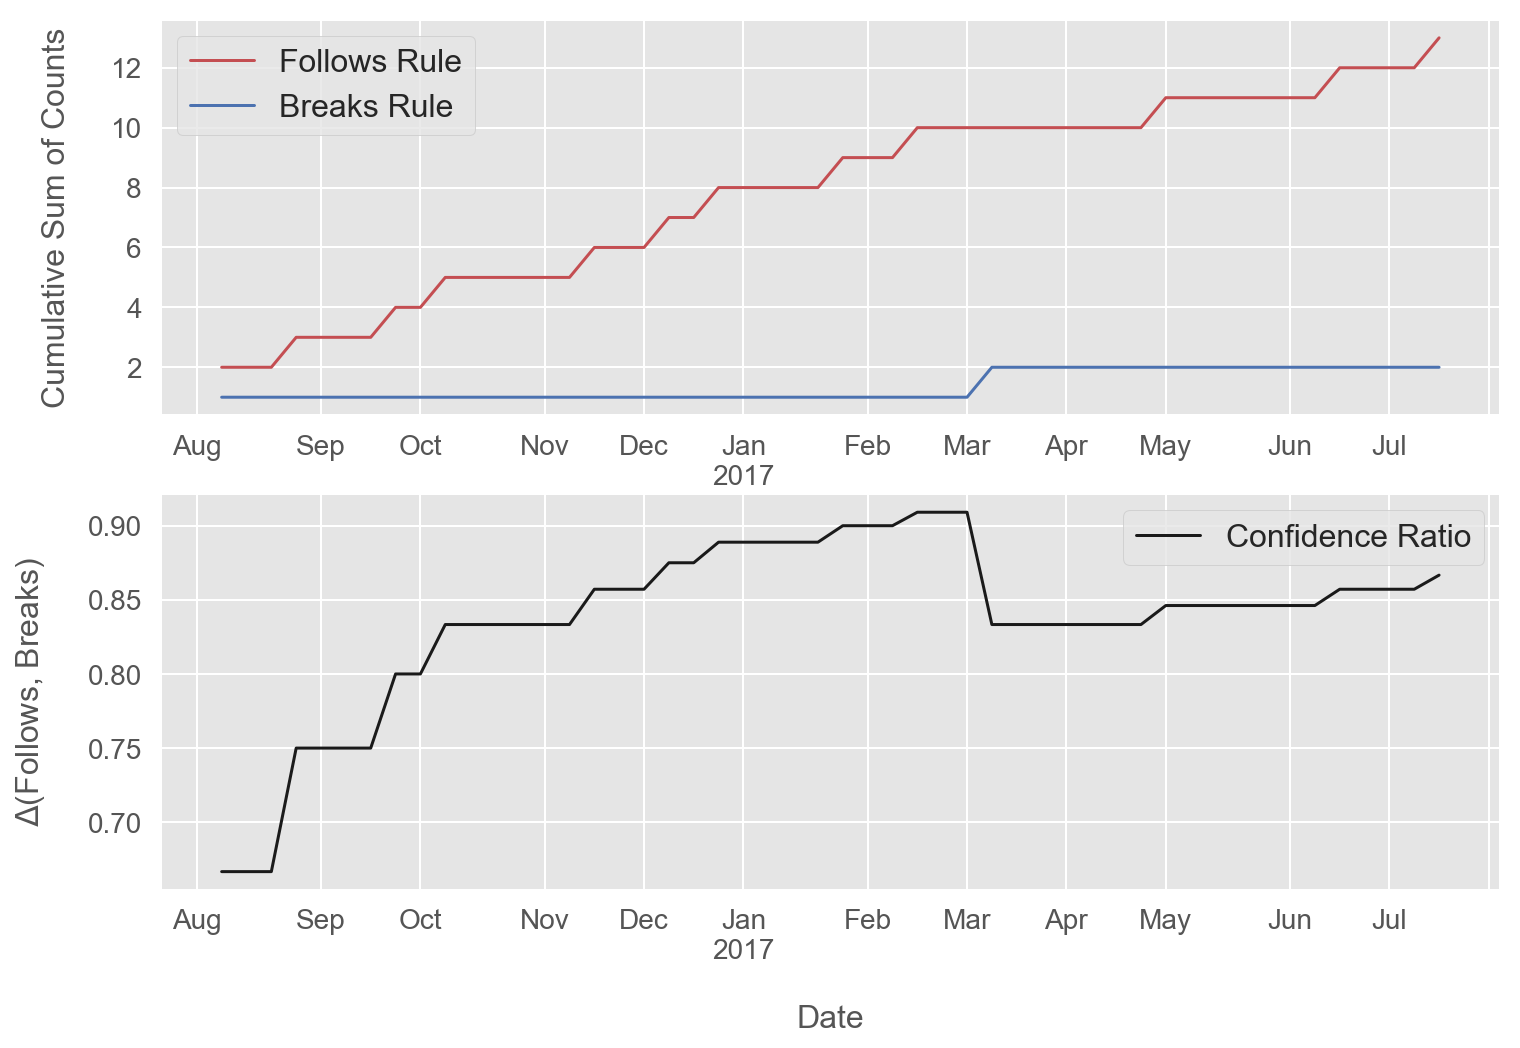

['Android Sticker Sheet Ultra Removable', 'Ballpoint Stick Pen 4 Pack'] -> ['Google Laptop and Cell Phone Stickers']


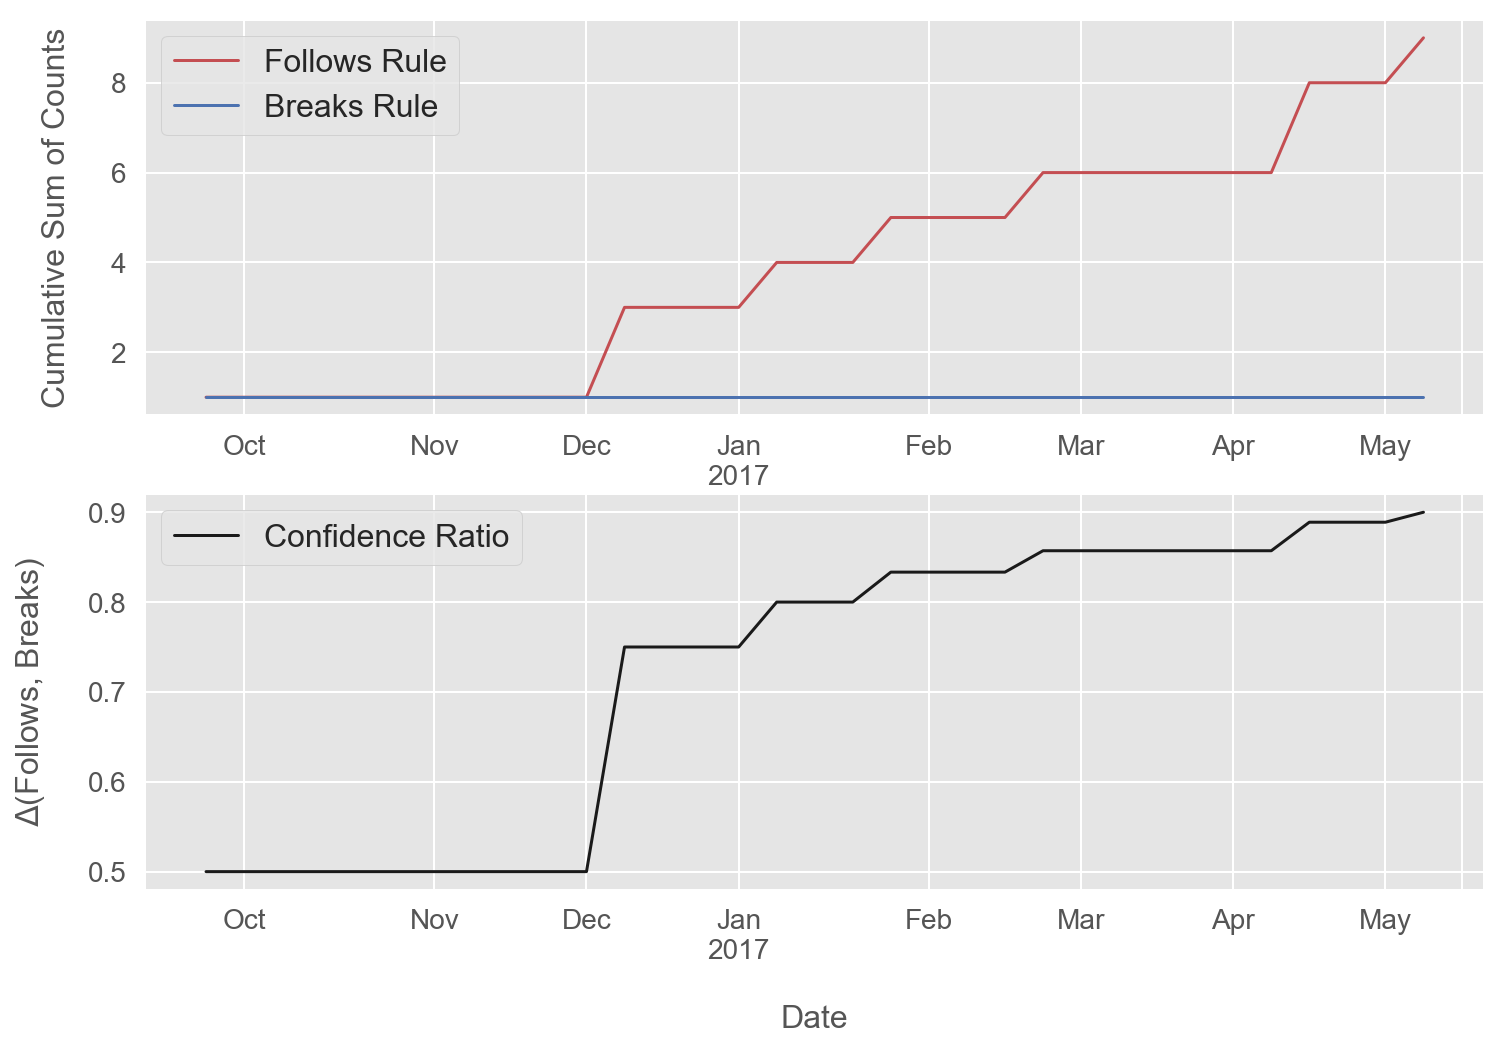

['Galaxy Screen Cleaning Cloth', 'Maze Pen', 'Sport Bag'] -> ['Google 22 oz Water Bottle']


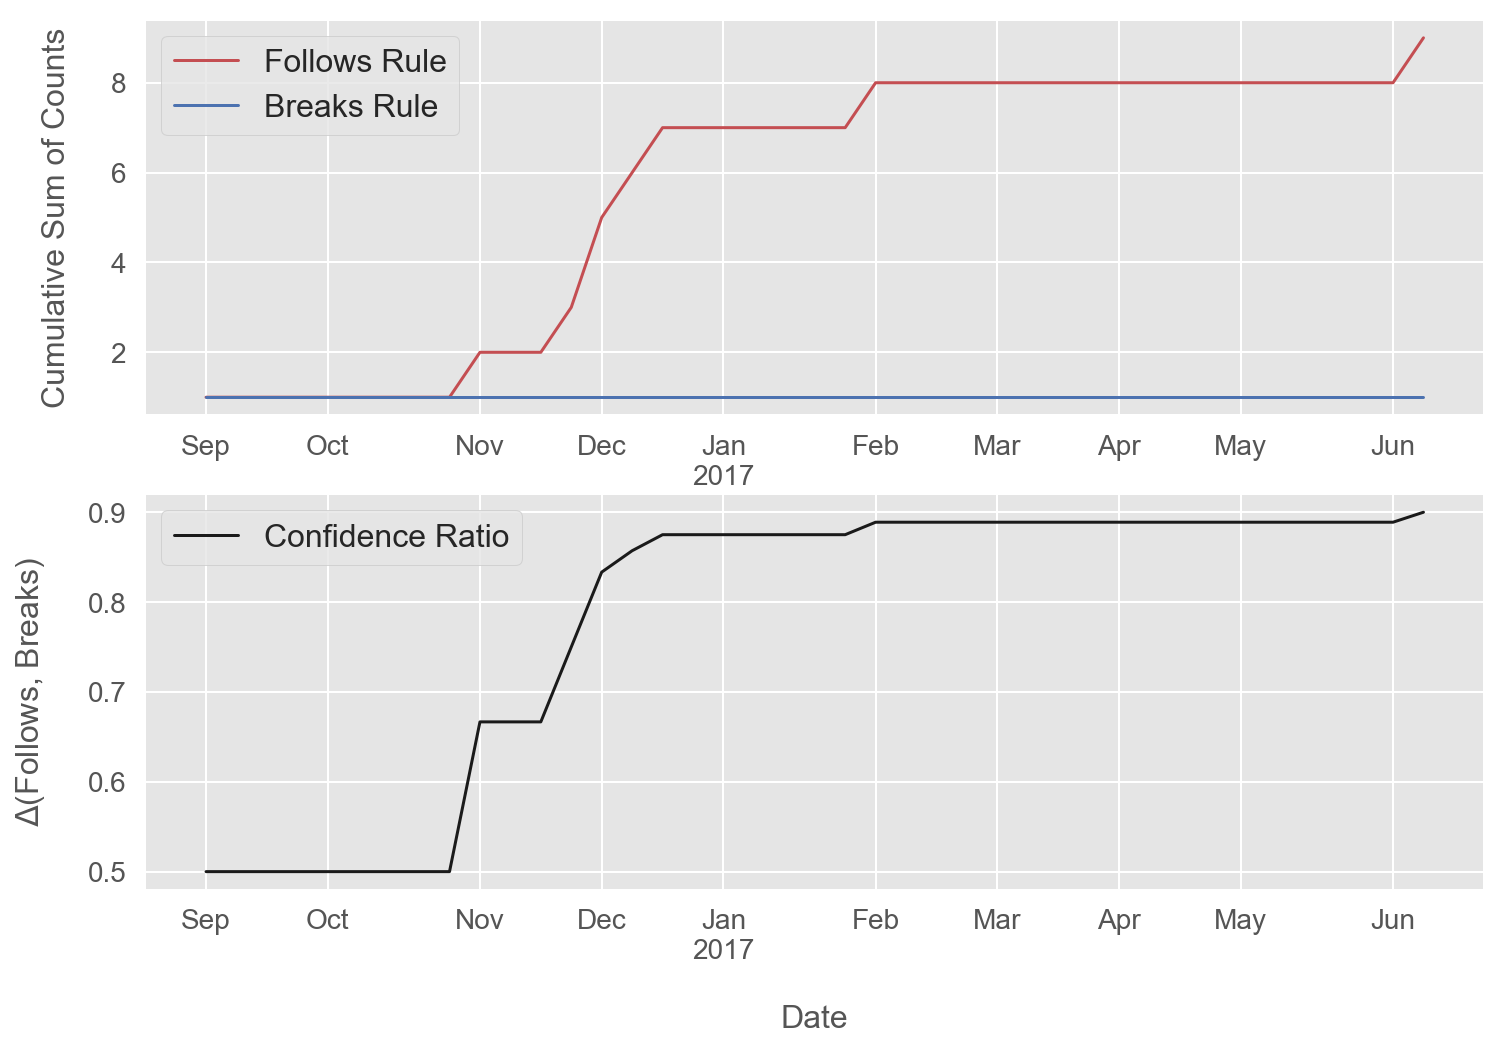

['Android Sticker Sheet Ultra Removable', 'Sport Bag'] -> ['Google Laptop and Cell Phone Stickers']


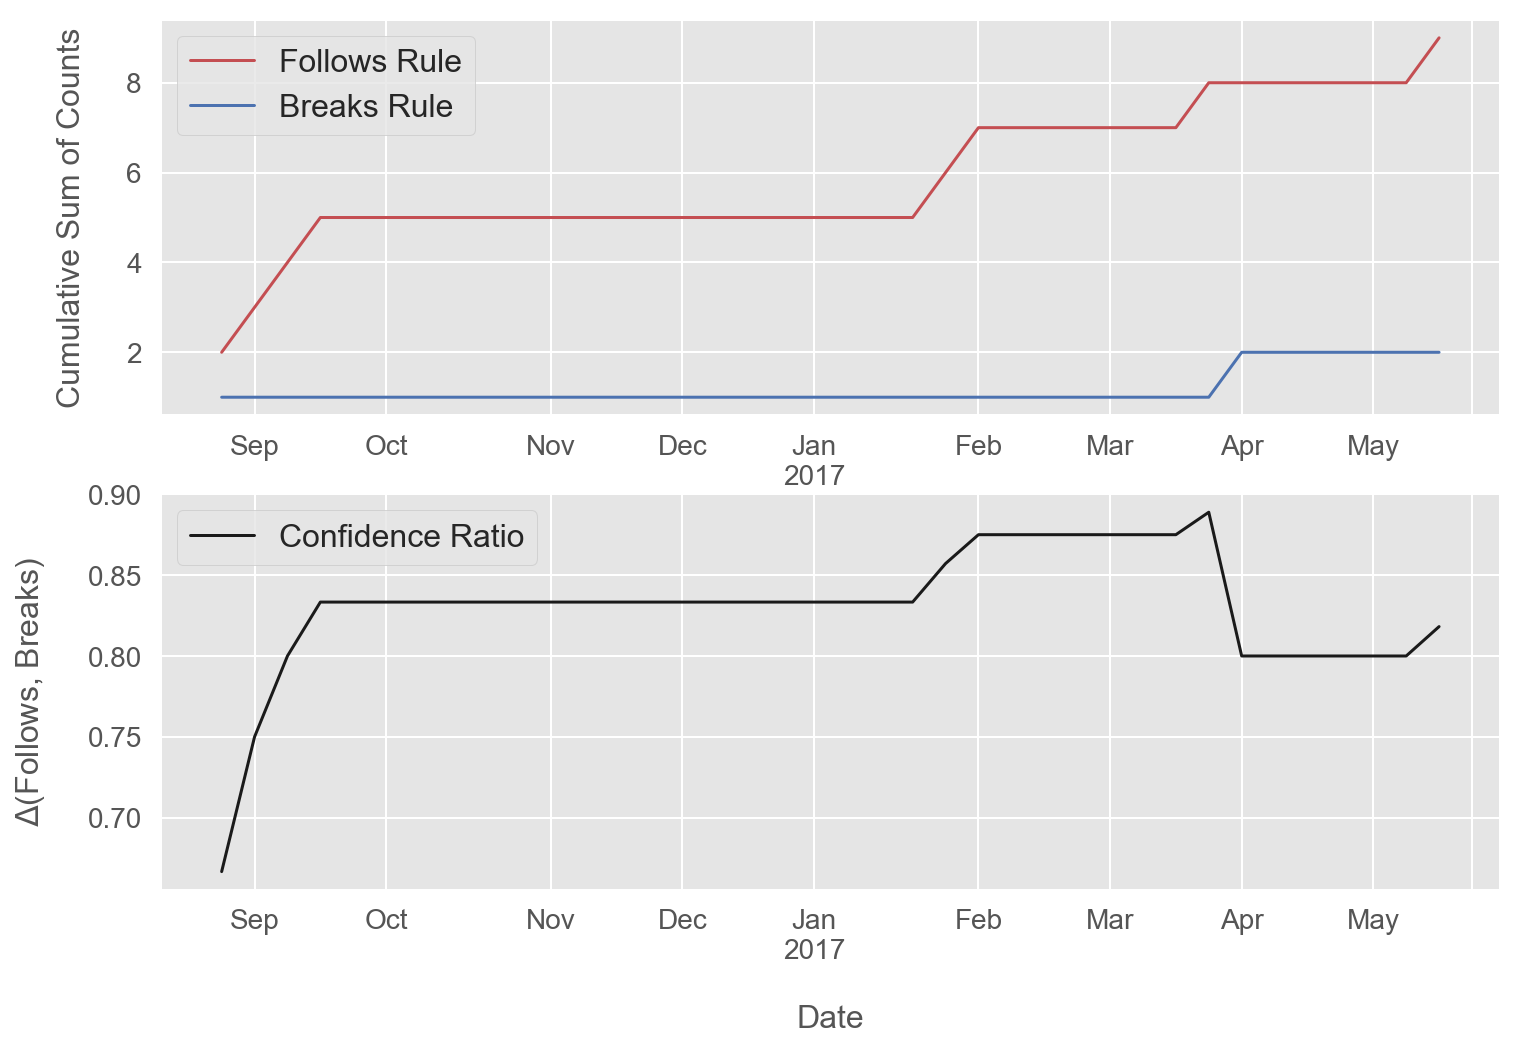

['Maze Pen', 'Badge Holder', 'Sport Bag'] -> ['Google 22 oz Water Bottle']


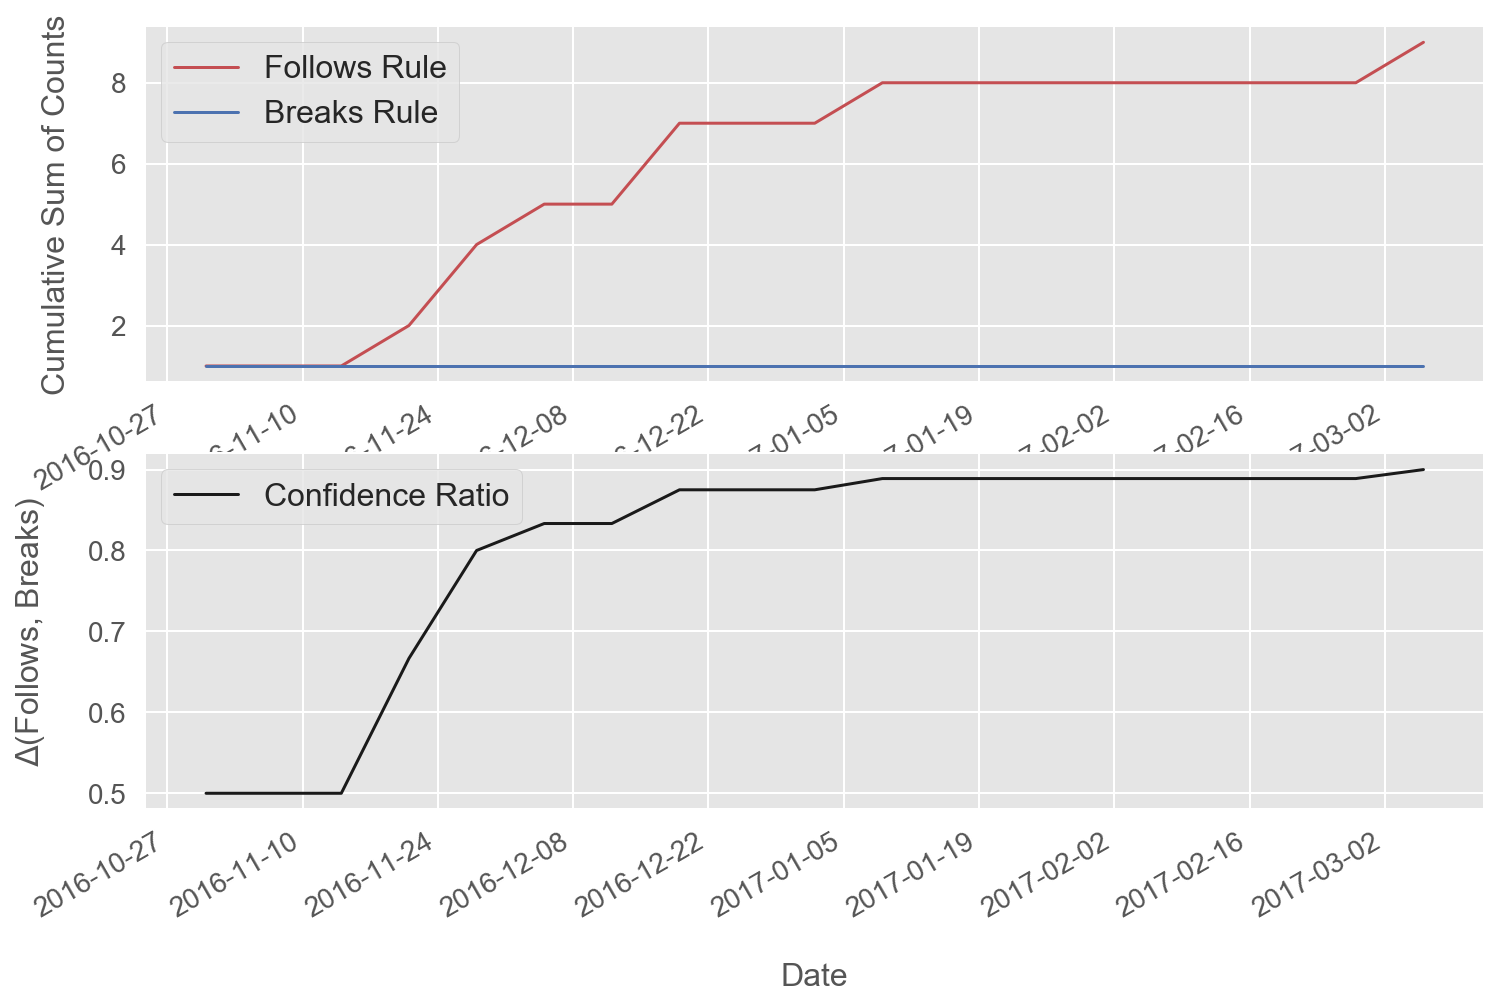

['Recycled Paper Journal Set', 'Retractable Ballpoint Pen Red'] -> ['Google 22 oz Water Bottle']


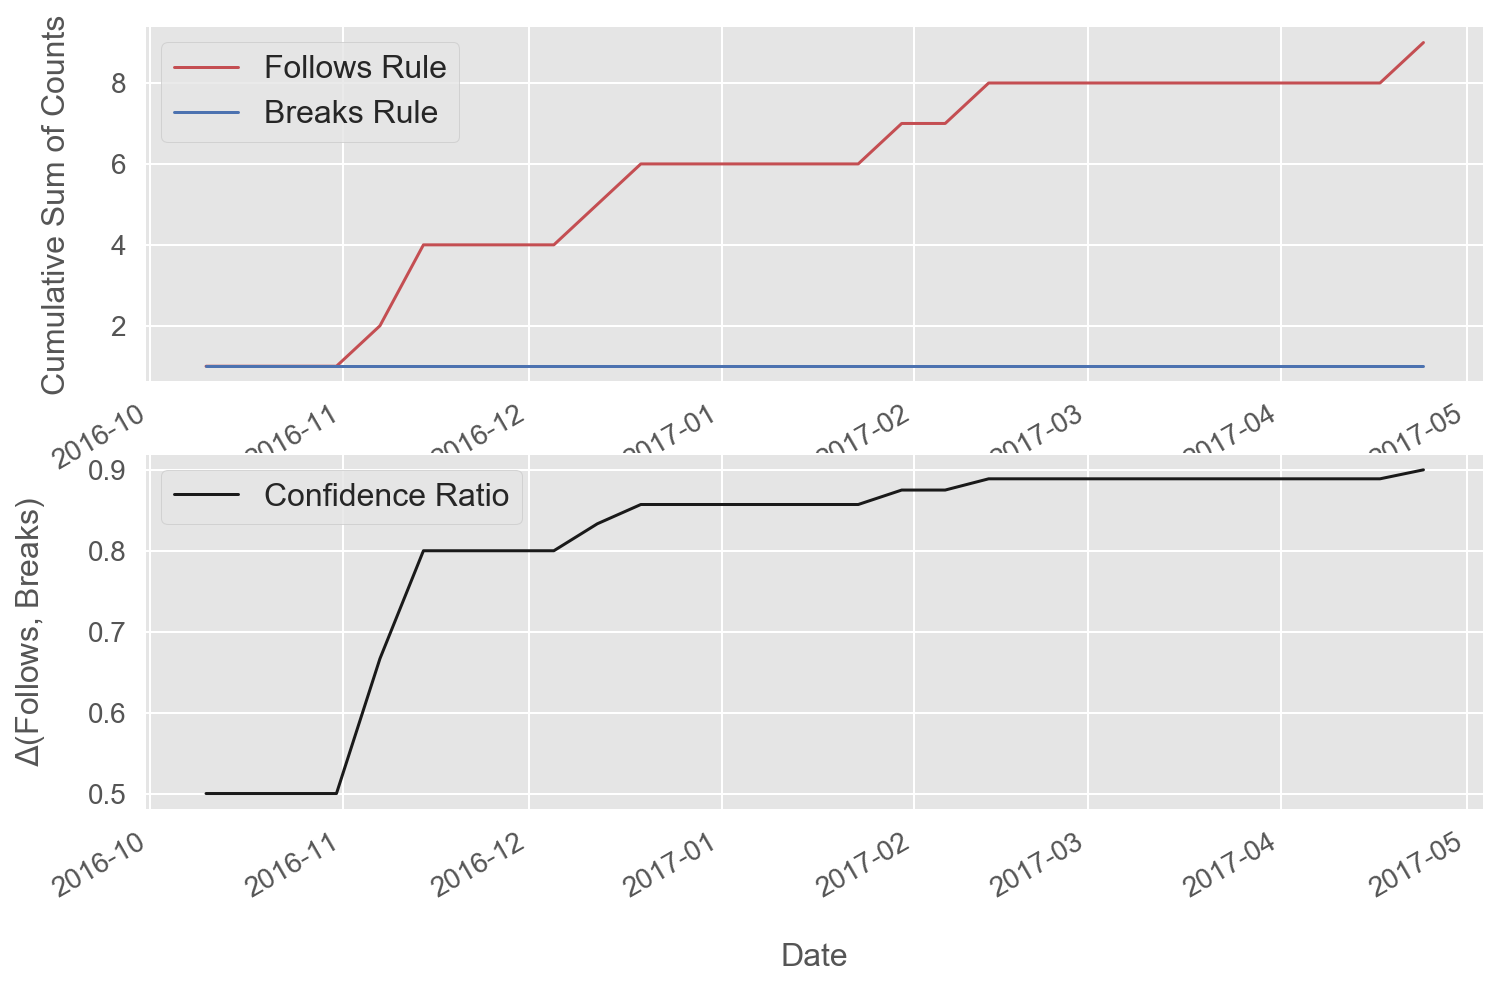

['Galaxy Screen Cleaning Cloth', '8 pc Android Sticker Sheet'] -> ['Google Laptop and Cell Phone Stickers']


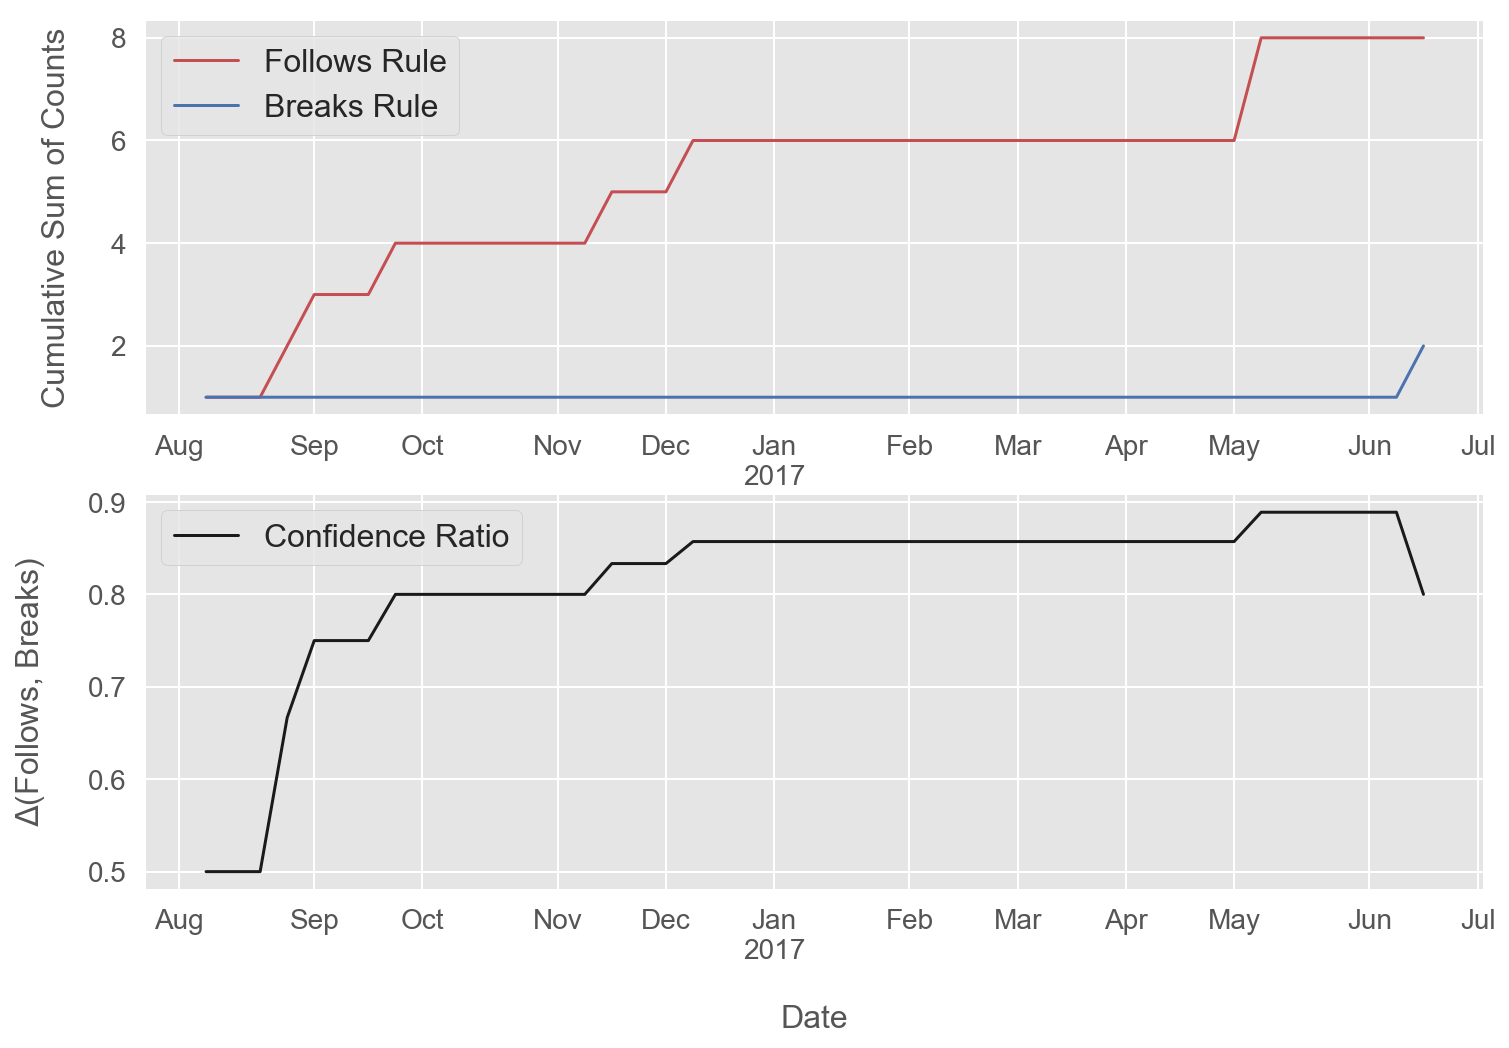

['Ballpoint Pen Blue', '1 oz Hand Sanitizer', 'Google Kick Ball'] -> ['Maze Pen']


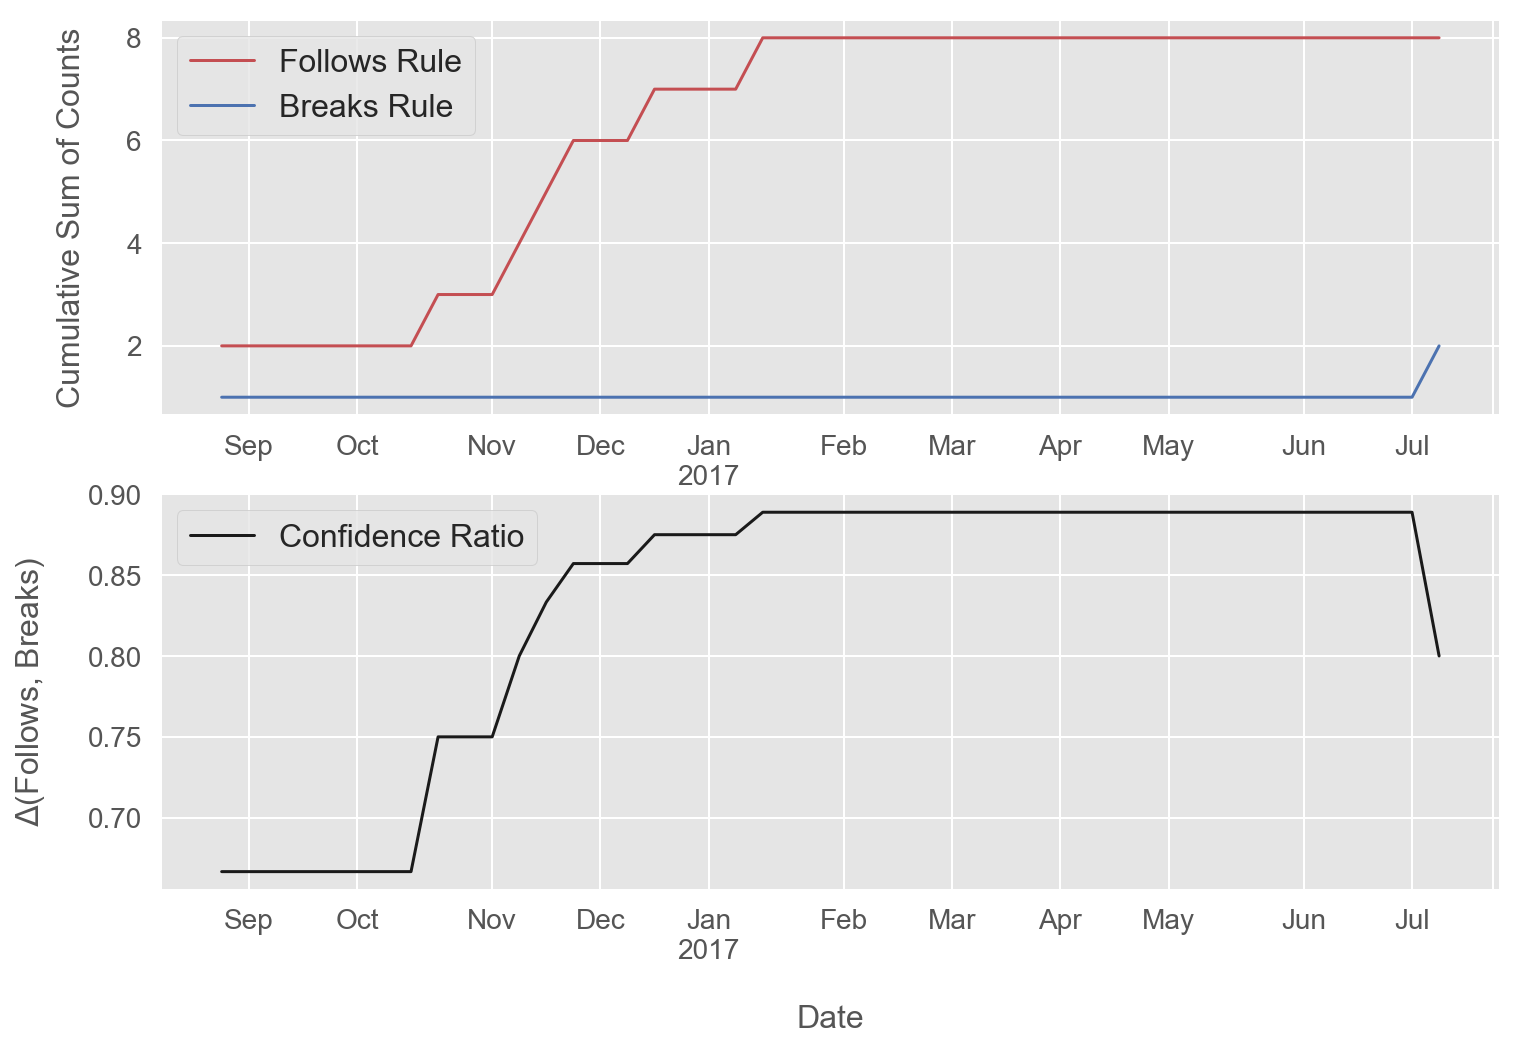

['Google 22 oz Water Bottle', 'Android Sticker Sheet Ultra Removable', 'Google Sunglasses'] -> ['Google Laptop and Cell Phone Stickers']


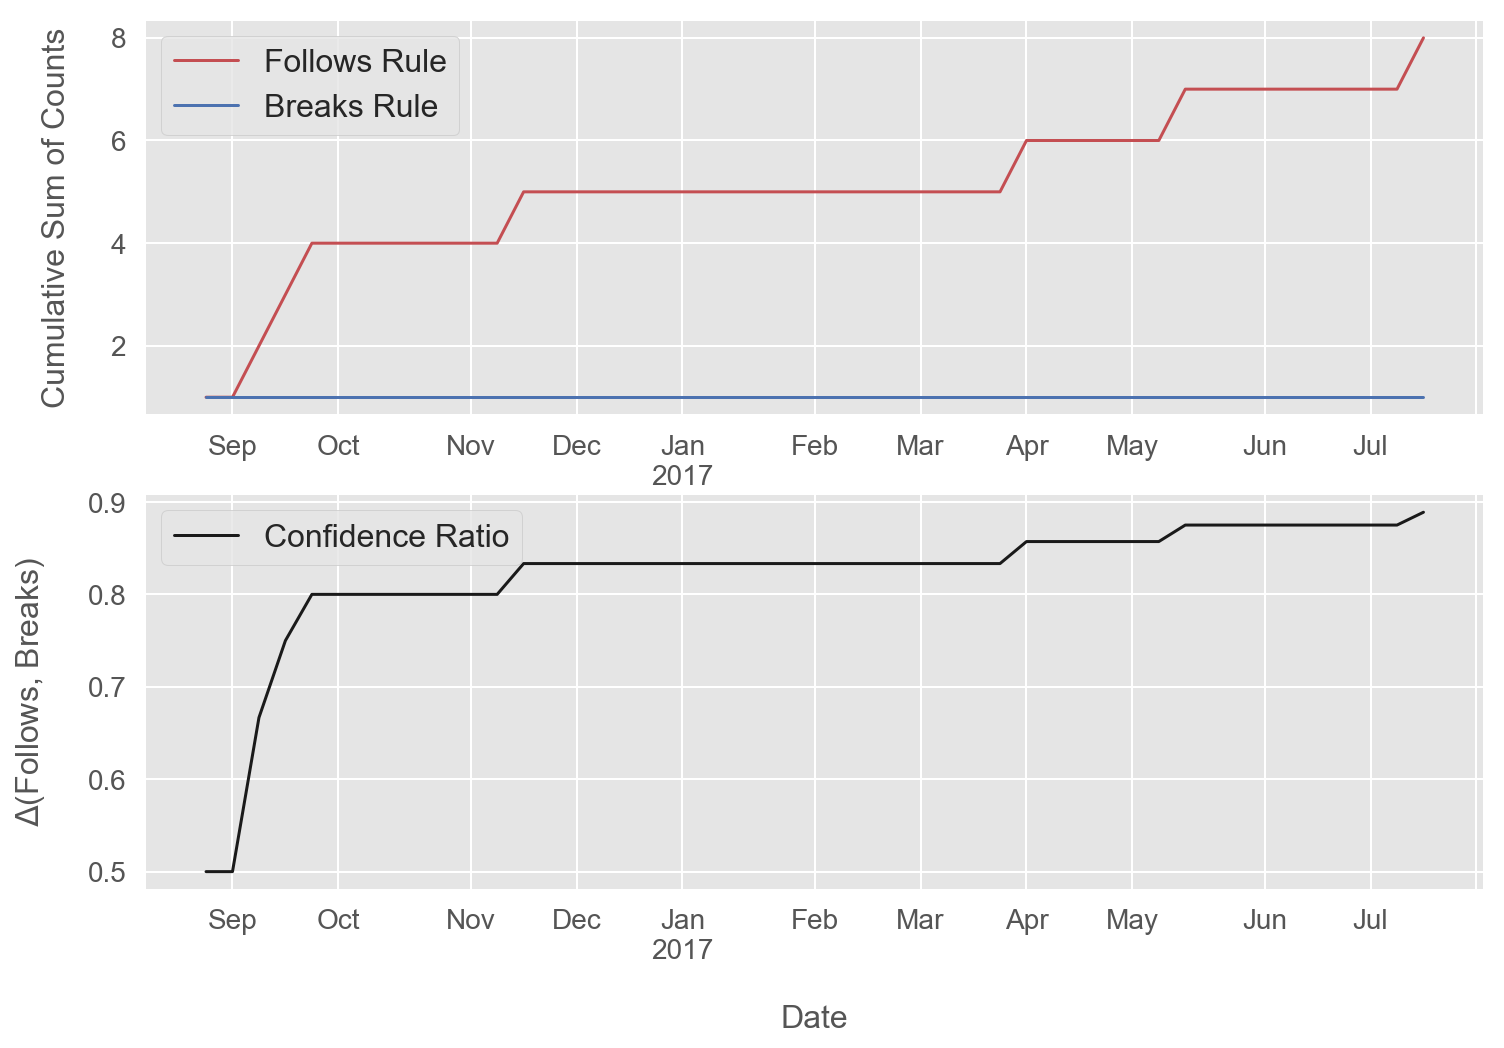

['Keyboard DOT Sticker', 'Ballpoint Pen Blue'] -> ['Google Laptop and Cell Phone Stickers']


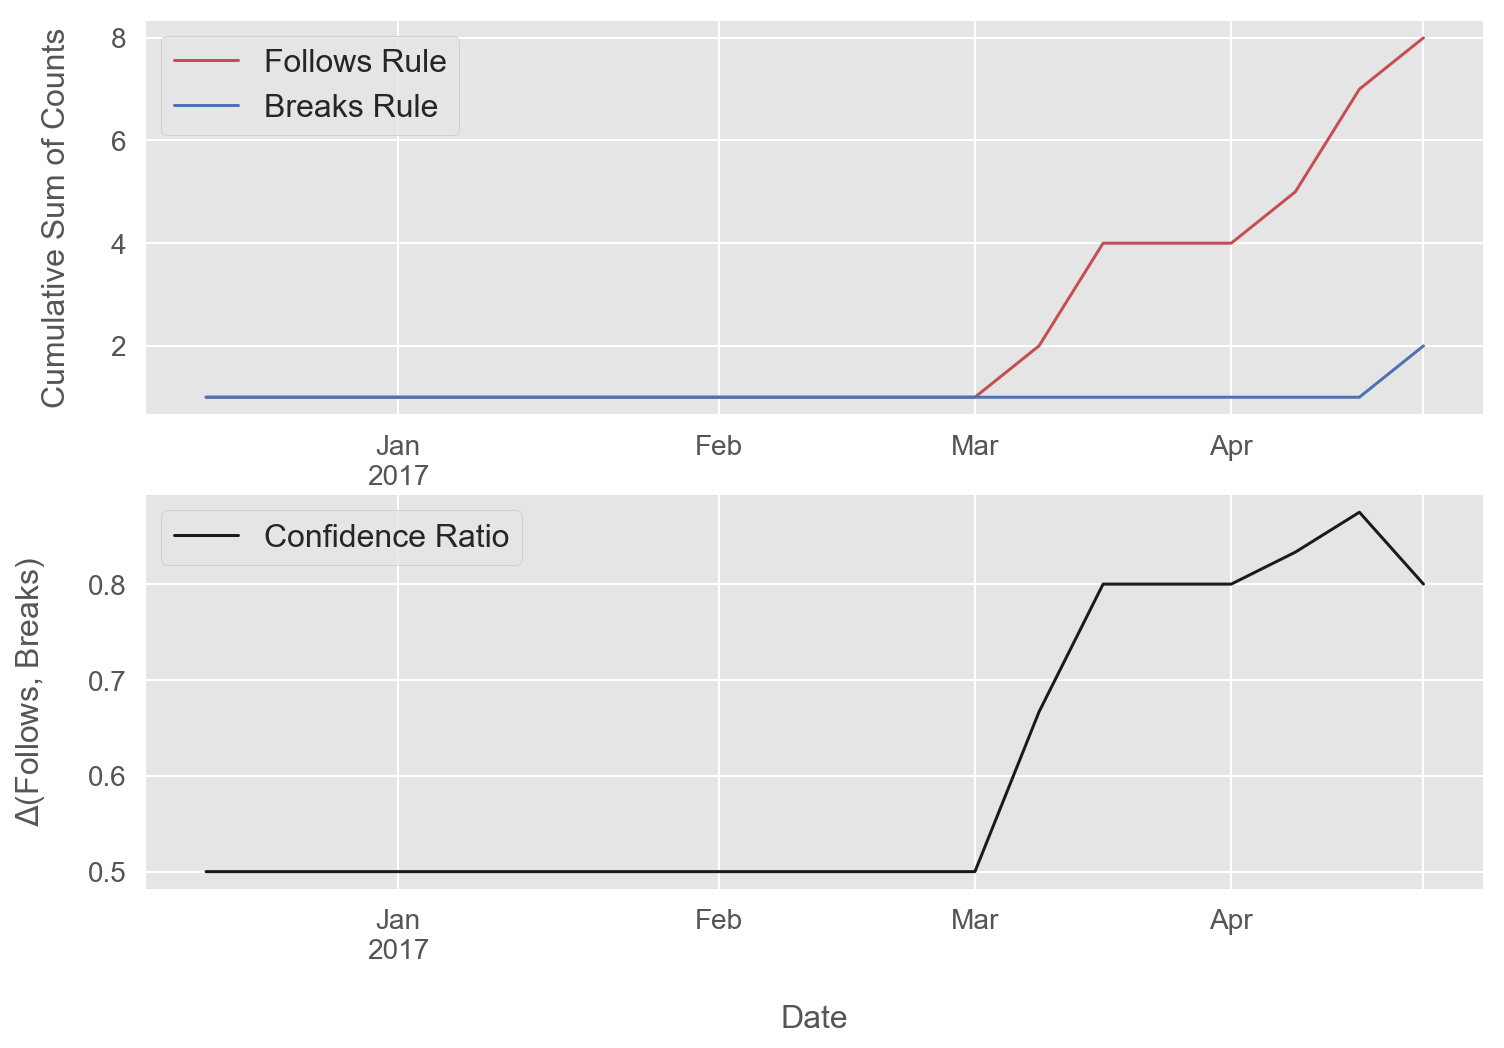

["Google Men's 100% Cotton Short Sleeve Hero Tee White", 'Google Doodle Decal'] -> ['Google Laptop and Cell Phone Stickers']


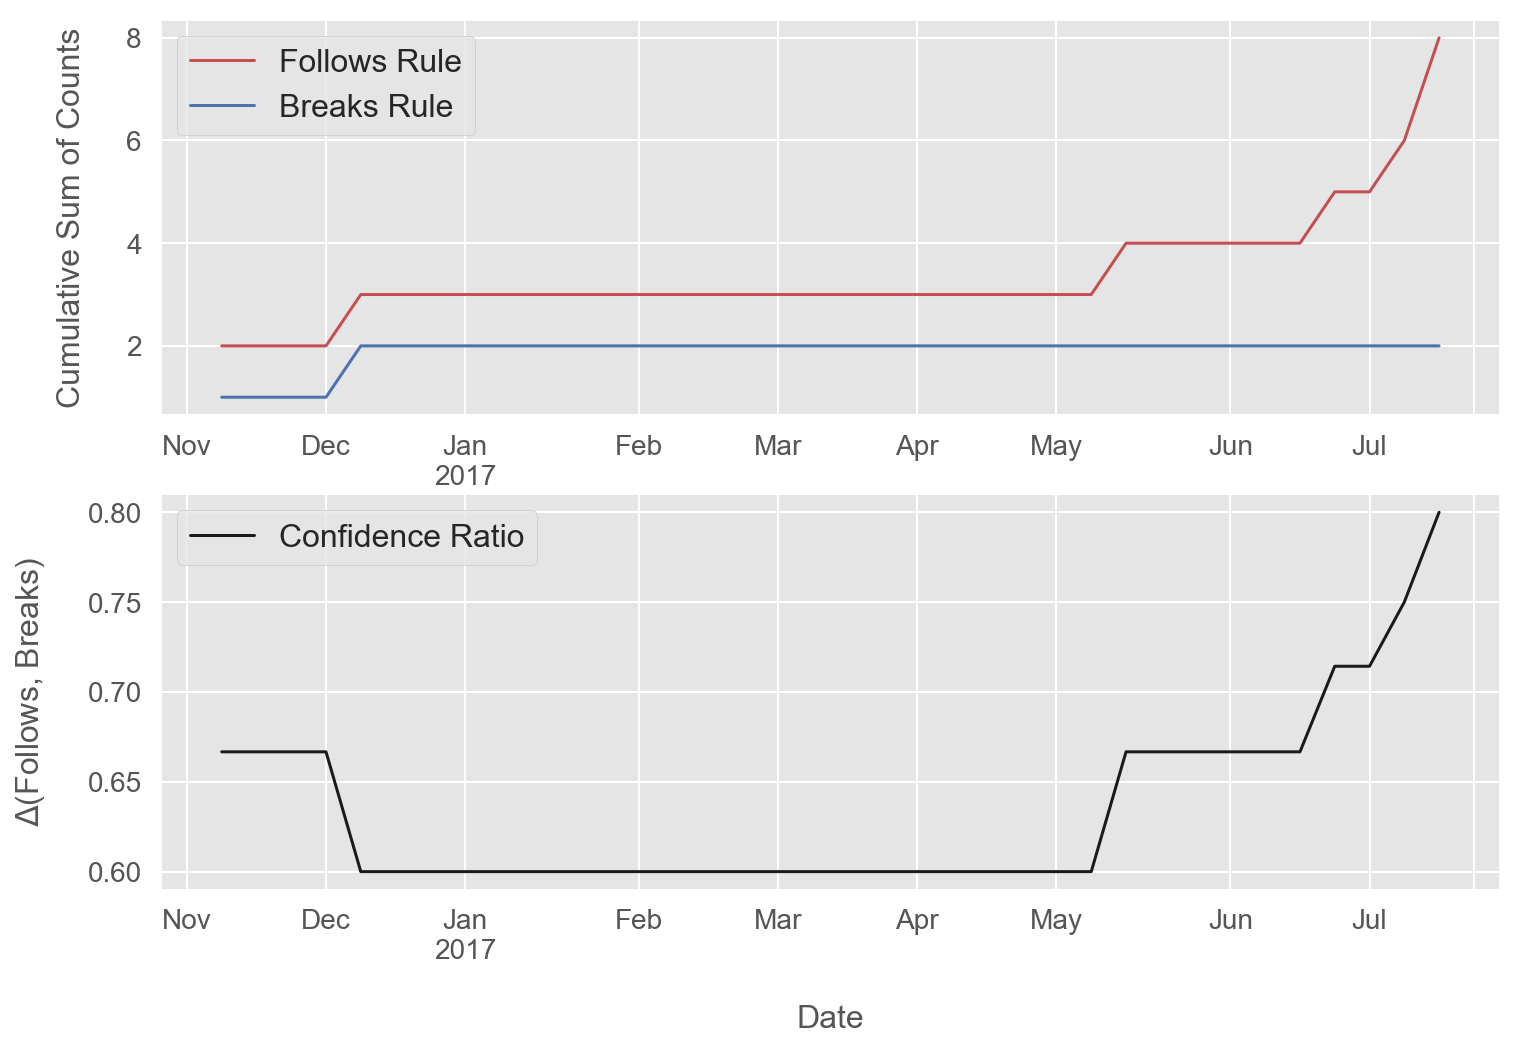

['Galaxy Screen Cleaning Cloth', 'Colored Pencil Set'] -> ['Google Laptop and Cell Phone Stickers']


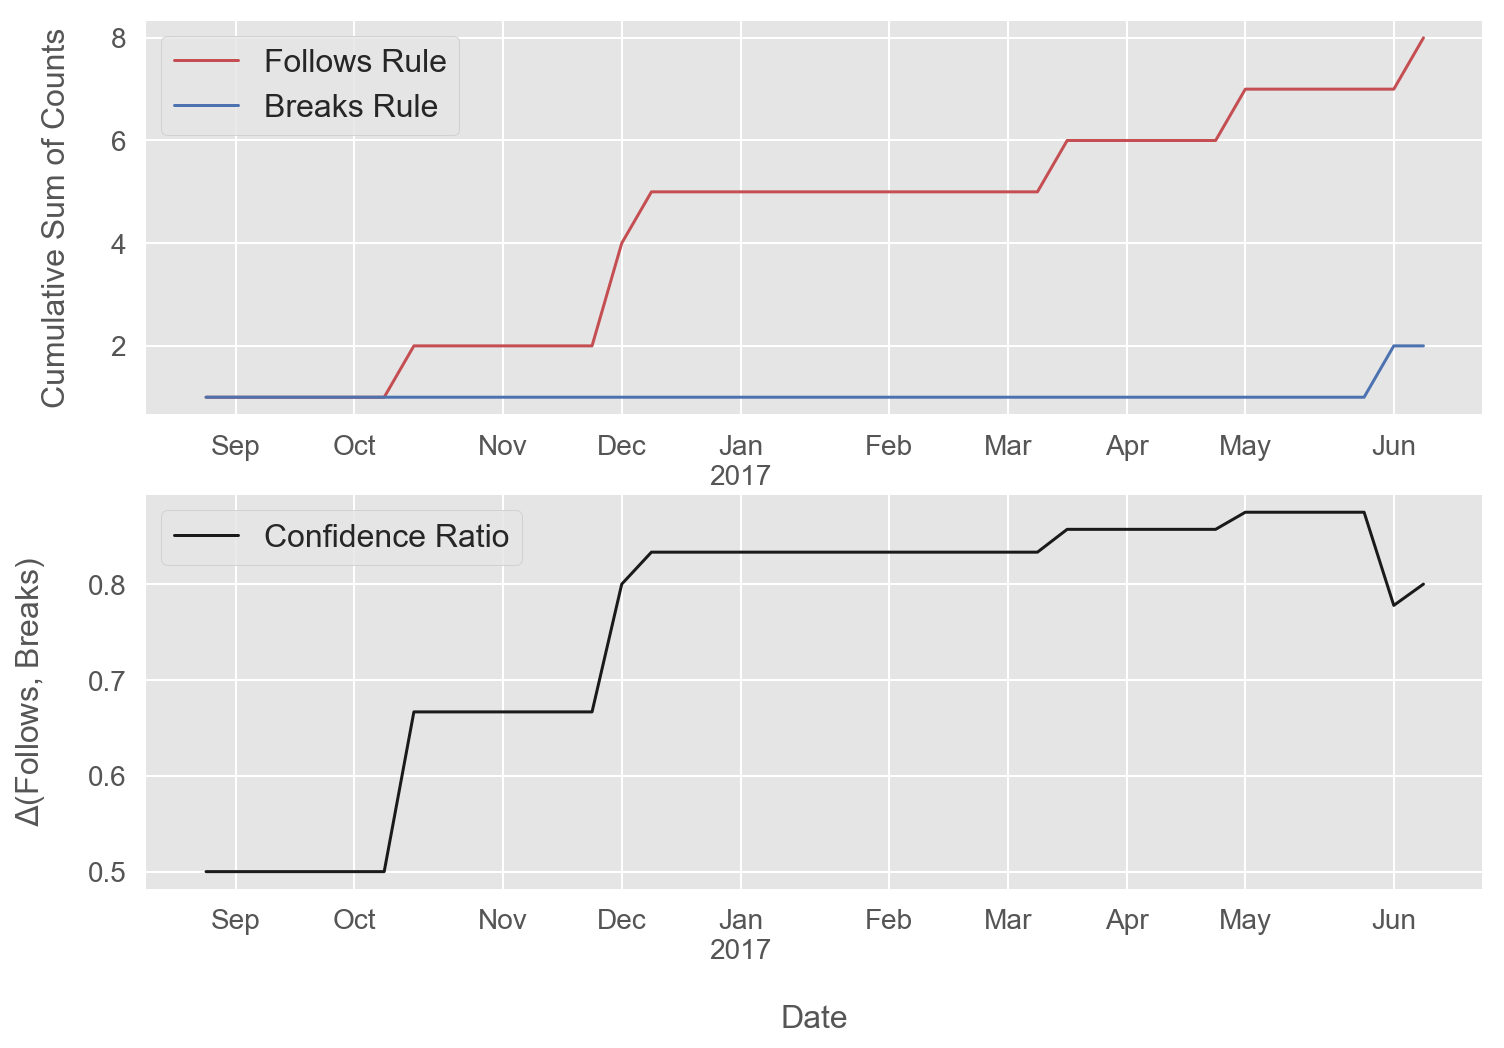

['YouTube Leatherette Notebook Combo', 'Android Rise 14 oz Mug'] -> ['Collapsible Shopping Bag']


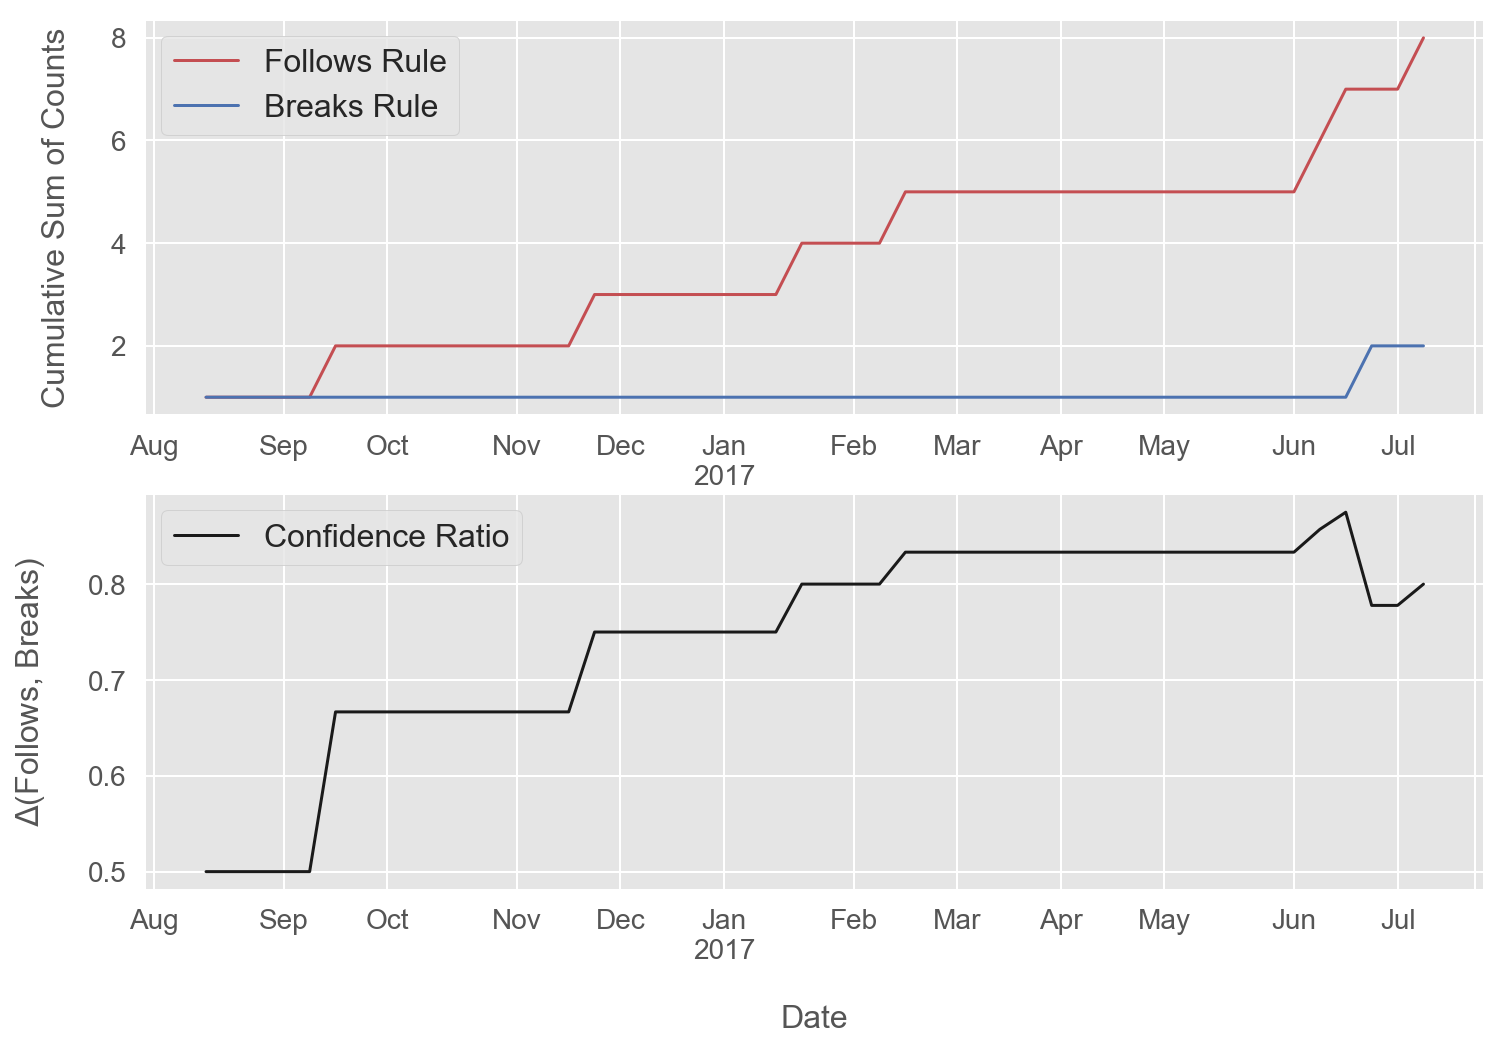

['Engraved Ceramic Google Mug', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']


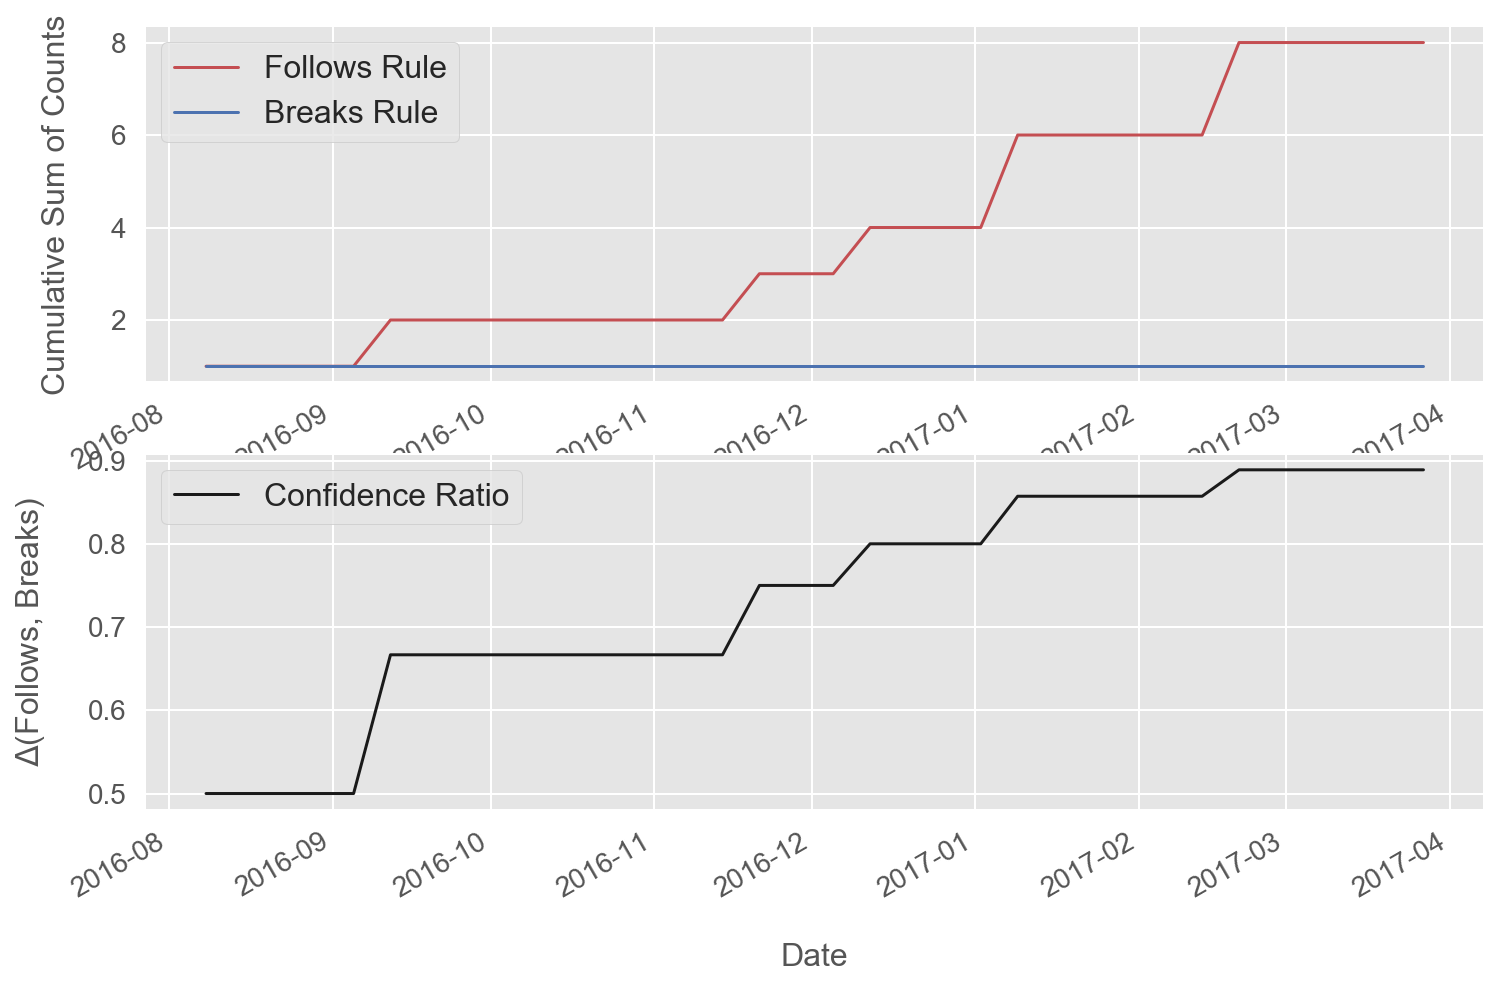

['Google Laptop and Cell Phone Stickers', 'Reusable Shopping Bag', 'Recycled Mouse Pad'] -> ['Google 22 oz Water Bottle']


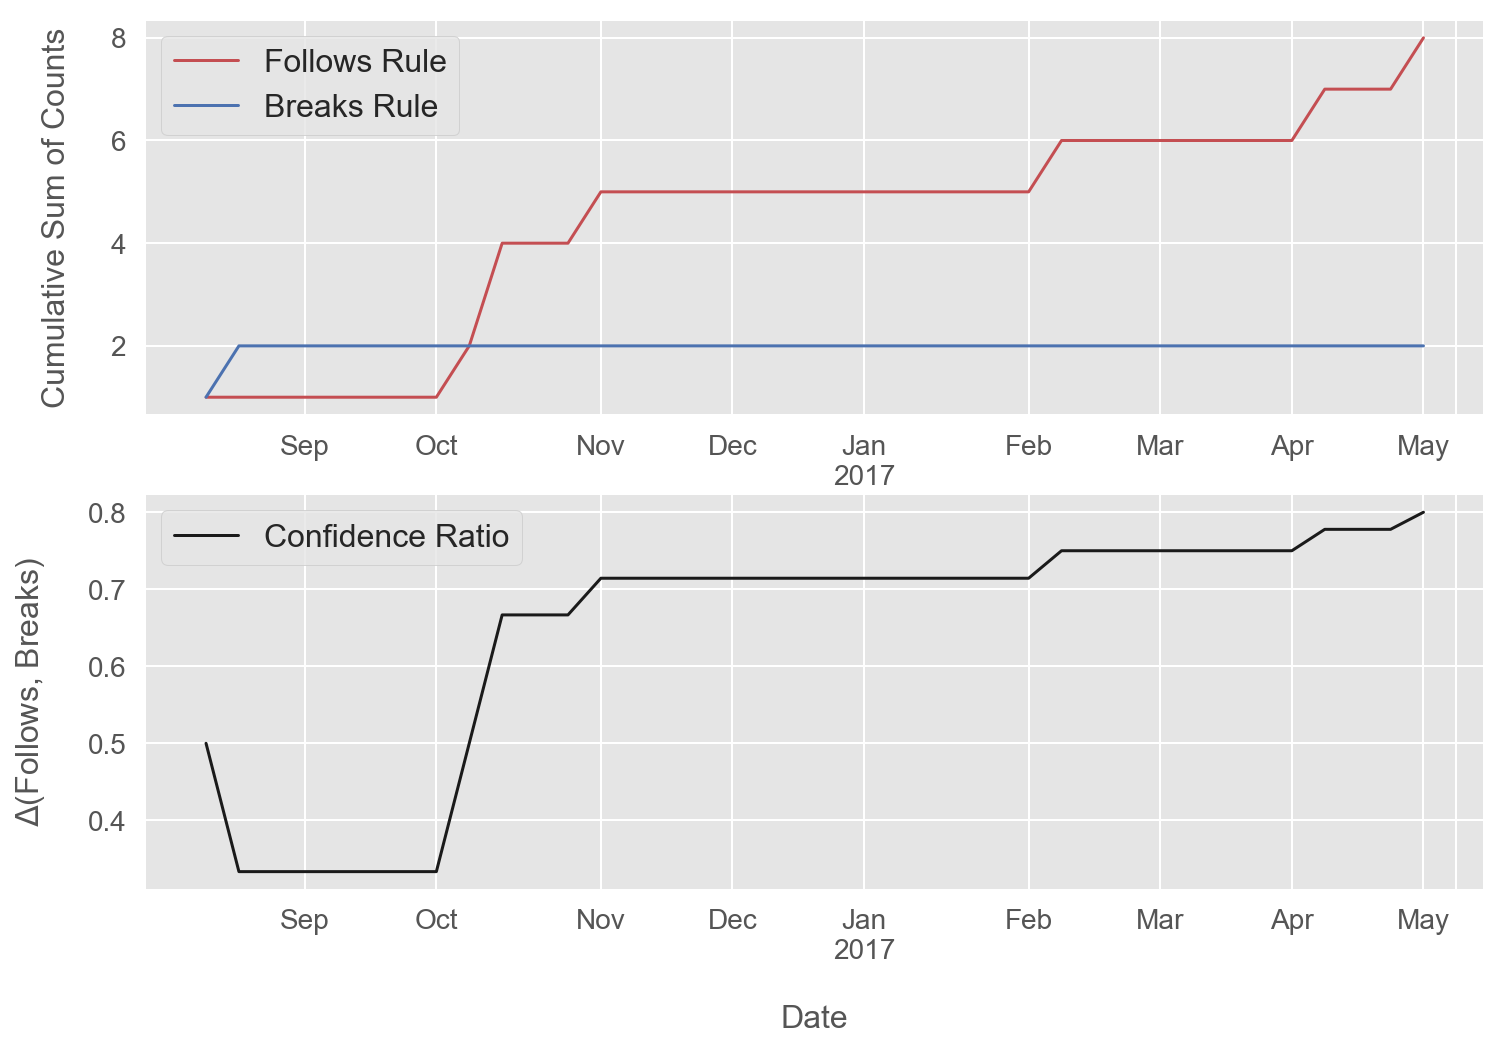

In [247]:
top_rules = rules.sort_values('support', ascending=False).head(20)

for rule in pd.concat((
        top_rules['antecedents'].apply(list),
        top_rules['consequents'].apply(list),
    ), ignore_index=True, sort=False, axis=1).values.tolist():
    plot_association_rule_trend(
        df_itemsets_by_transaction_no_variants,
        rule,
        save_to_file=False,
    )

Picking a few of these to output

['YouTube Custom Decals', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']
Saving figure to file: ../../results/figures/association_rules_trended_confidence_8aeb8ed189.png


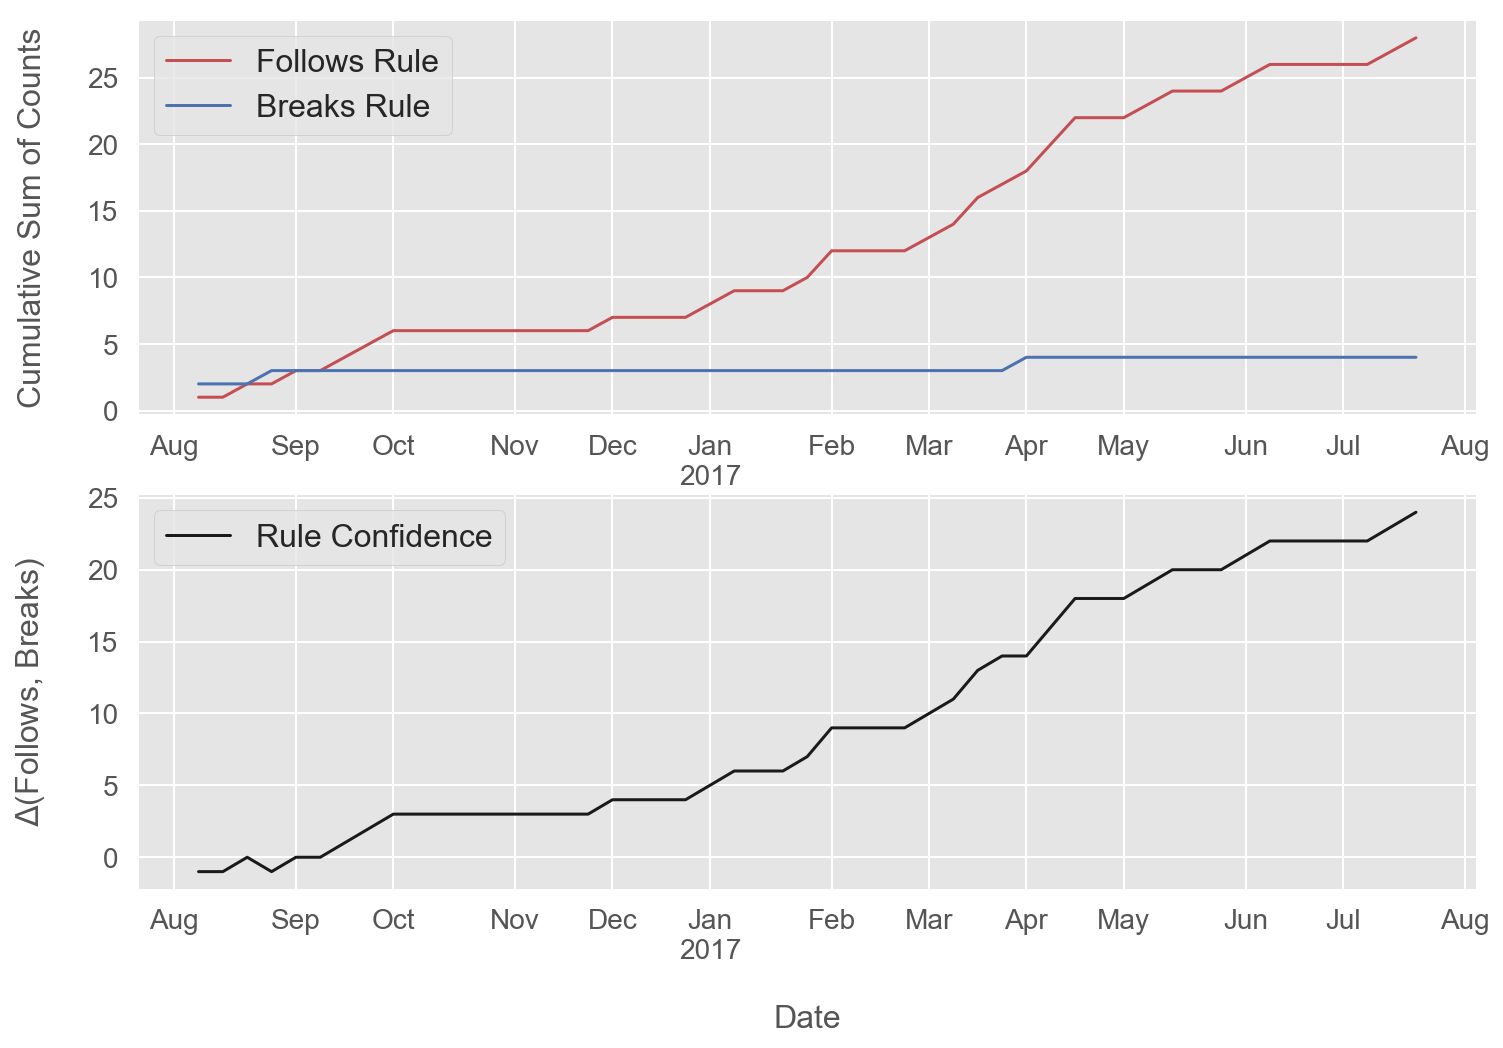

In [243]:
rule = [
    ['YouTube Custom Decals', 'Android Sticker Sheet Ultra Removable'],
    ['Google Laptop and Cell Phone Stickers'],
]
plot_association_rule_trend(df_itemsets_by_transaction_no_variants, rule)

['Red Shine 15 oz Mug', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']
Saving figure to file: ../../results/figures/association_rules_trended_confidence_3baa4d2620.png


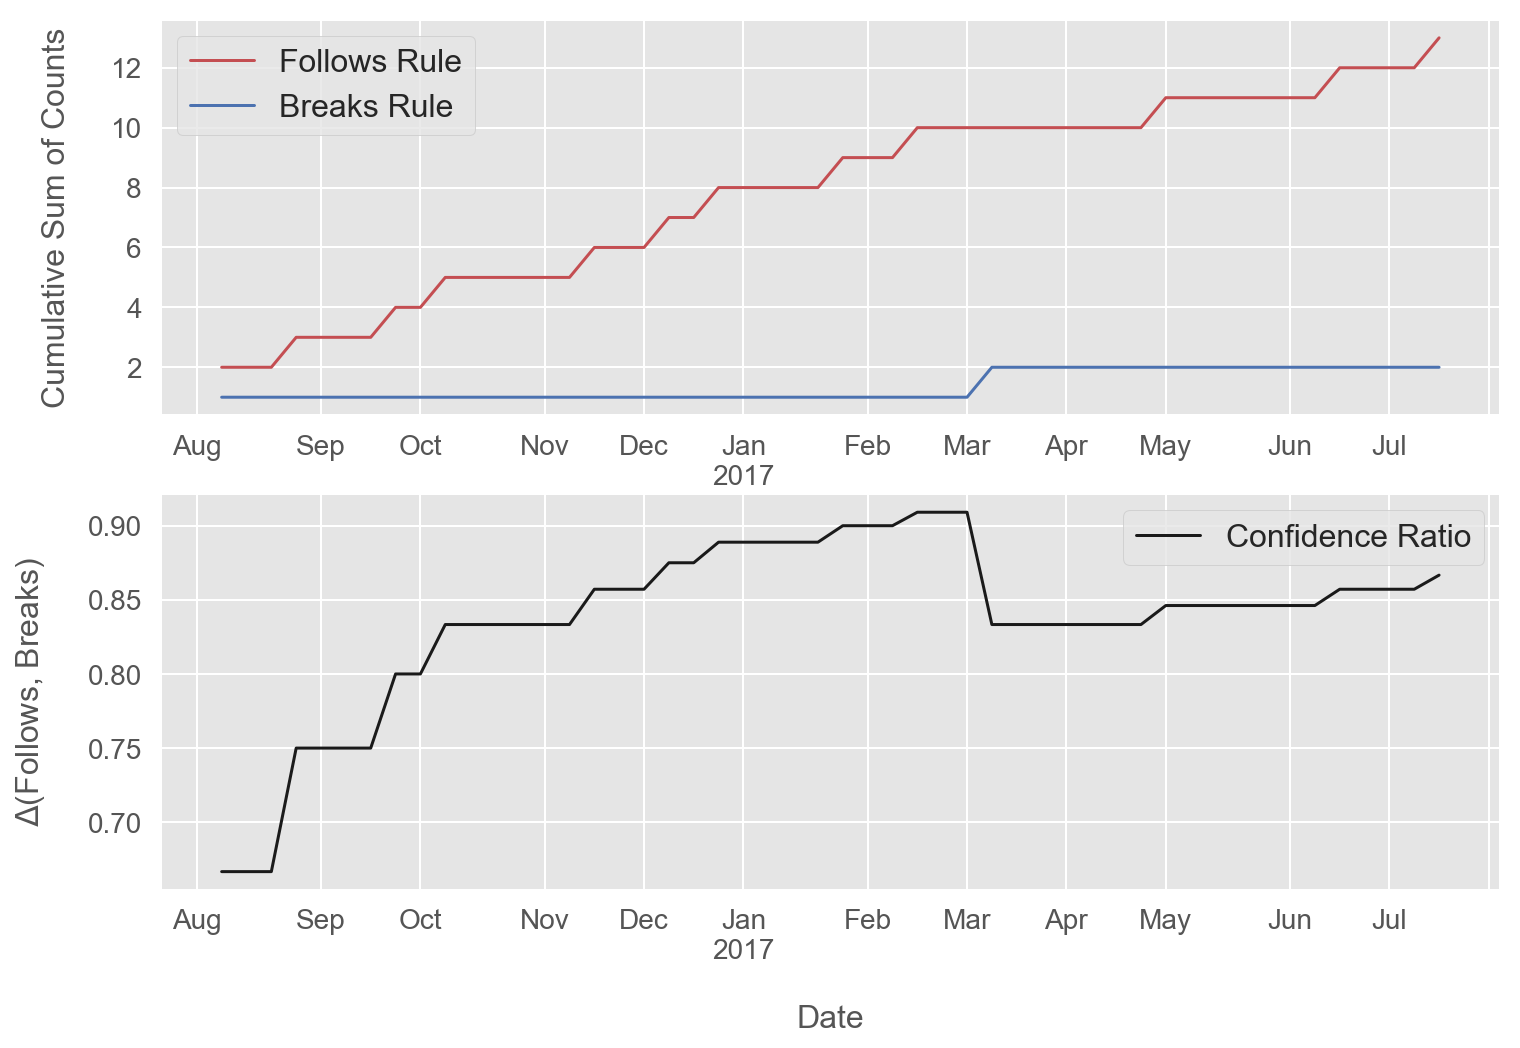

In [249]:
rule = [
    ['Red Shine 15 oz Mug', 'Android Sticker Sheet Ultra Removable'],
    ['Google Laptop and Cell Phone Stickers']
]
plot_association_rule_trend(df_itemsets_by_transaction_no_variants, rule)

In [250]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')